In [5]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from hurst import compute_Hc, random_walk
from statsmodels.tsa.stattools import acf
from math import log
from statsmodels.tsa.ar_model import AutoReg
def prepare_data(path):
    df = pd.read_csv(path)
    df.columns = ['Date_vix']
    df['Date'] = df['Date_vix'].apply(lambda x: x[0:8])
    df['vix'] = df['Date_vix'].apply(lambda x: x[9:])
    df['vix'] = df['vix'].apply(lambda x: str.replace(x, ' ', ''))
    df['vix'] = df['vix'].apply(lambda x: 0.0 if x == '.' else x)
    df['vix'] = df['vix'].astype(float)
    df['log_vix'] = np.log(df['vix'])
    df['Date'] = pd.to_datetime(df['Date'])
    return df


def obtain_train(df_ori):
    #

    # value_first = df_ori['residual'].values[0]
    # df_ori['residual'] = df_ori['residual'] - value_first
    # df_ori['residual_mean'] =  df_ori['residual'].mean()
    # df_ori['lr'] = 2 * np.linspace(0, 1, df_ori.shape[0]) * df_ori['residual'].mean()
    df_ori['x'] = df_ori['residual'] # - df_ori['lr']
    # df_ori['x'] = df_ori['residual']
    df_ori['y'] = df_ori['x'].diff()
    # print("value_first in obtain_train is ", value_first)
    
    return df_ori,0 # value_first


def obtain_train_ar(df, n, date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

def obtain_gamma(value):
    value_ = np.power(gamma((value + 1) / 2), 2) / gamma(value + 0.5)
    return value_ / np.sqrt(np.pi)


def obtain_lambda(target):
    left = 0
    right = 3
    mid = (left + right) / 2
    while abs(obtain_gamma(mid) - target) > 10 ** -8:
        if obtain_gamma(mid) > target:
            left = mid
            mid = (left + right) / 2
        elif obtain_gamma(mid) < target:
            right = mid
            mid = (left + right) / 2
        else:
            return mid
    return mid

def obtain_residual_by_ar(df_):
    acf_params_ = acf(df_['log_vix'],nlags=50)
    model_ = AutoReg(df_['log_vix'], lags=3).fit()
    predict = model_.predict()
    print("predict is ", predict)
    df_['ar_predict'] = predict.values

    df_['residual'] = df_['log_vix']-df_['ar_predict']

    forecast  =model_.forecast(1)
    return model_.params,df_, forecast


def objective_function(x, a,b):
    err = []
    for i in range(len(a)-1):
        err.append(np.power(a[i+1]-x[0]*a[i]-x[1]*b[i+1]-x[2],2)) # 可以加入对过去的多个依赖
    # print(err)
    return np.sum(err) #np.sqrt(np.sum(err))

from scipy.optimize import minimize, LinearConstraint

In [6]:
# def obtain_true(df,n,date):
#     df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
#     value_first = df_ori['log_vix'].values[0]
#     df_ori['log_vix'] = df_ori['log_vix'] - value_first
#
#     return df_ori,value_first

def obtain_true_ar(df,n,date):
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    return df_ori

In [7]:
def hmse(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(np.power((ratio[abs(ratio)<200]-1),2))

def hmae(y_true,y_pred):
    ratio = y_pred/y_true

    # print(ratio[abs(ratio)<2])
    return np.mean(abs(ratio[abs(ratio)<200]-1))

In [8]:
def calculate_aic(n, mse, num_params):
    """
    compute aic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    aic = n * log(mse) + 2 * num_params
    return aic


def calculate_bic(n, mse, num_params):
    """
    compute bic
    :param n:
    :param mse:
    :param num_params:
    :return:
    """
    bic = n * log(mse) + num_params * log(n)
    return bic



In [9]:
def obtain_v(data,H):
    n = data.shape[0]
    S = np.zeros([n+2,n+2])

    for i in range(1,n+2):
        for j in range(1,n+2):
            S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/(2*(n+1)**(2*H))
    S = S[1:,1:]
    A = S[0:n,0:n]
    A_ = np.linalg.inv(A)
    B_T = S[-1,0:n]
    print("A shape is ", A.shape)
    print("B_T shape is ", B_T.shape)
    print("data shape is ", data.shape)
    print("data['u'].values[-1] = ", data['u'].values[-1],np.dot(B_T.reshape(1,-1),A_))
    print("debug"*5,np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0])
    v = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]-data['u'].values[-1]
    u_hat = np.dot(np.dot(B_T.reshape(1,-1),A_),data['u'].values.reshape(-1,1))[0]
    return v,u_hat

In [10]:
def obtain_params(data):
    log_vix = data['log_vix'].values
    z_i = data['z_i'].values
    res = minimize(
    objective_function,
    x0=0.5 * np.random.random(3),
    args=(log_vix,z_i),
)
    return res

In [11]:
# def predict_self(data,v,x,lambda_):
#     z = np.sign(v)*np.power(abs(v),lambda_)
#     result = data['y'].values[-1]*x[0]+z*x[1]+x[2]    #####
#     return result

def compute_z(v,lambda_):
    return np.sign(v)*np.power(abs(v),lambda_)


In [12]:
def main(date, n = 500):
    df = prepare_data('./data/VIXdata.txt')
    df_ori = df[df['Date'] >= date][0:n].reset_index(drop=True)
    params_ar,df_ori, forecast = obtain_residual_by_ar(df_ori)
    forecast = forecast.values
    print("forecast is ", forecast)
    print("df_ori after obtain_residual_by_ar is ", df_ori.head(30))
    df_ori = df_ori.dropna()
    df_ori,value_first = obtain_train(df_ori)
    df_ = df_ori.dropna()
    print("debug here df_", df_.head())

    df_['abs_y'] = np.abs(df_['y'])
    df_['squared'] = df_['y']*df_['y']
    R1n = df_['abs_y'].mean()
    R2n = df_['squared'].mean()
    lambda_ = obtain_lambda(R1n*R1n/R2n)
    print("lambda_ =", lambda_)
    df_['y_tilde'] = np.sign(df_['y'])*np.power(df_['abs_y'],1/lambda_) #+1/lambda_
    df_['u'] = np.cumsum(df_['y_tilde'])
    df_['z_i'] = df_[['y','y_tilde']].apply(lambda x:np.sign(x[0])*np.power(abs(x[1]),lambda_),axis=1)
    series = df_['u'].values  # create a random walk from random changes
    print("series is ", series)
    # Evaluate Hurst equation
    H, c, data = compute_Hc(series, kind='random_walk', simplified=True)
    v,u_hat = obtain_v(df_,H)
    print("v = ", v)
    u_tmp = np.sign(df_['u'].values[-1])* np.power(np.abs(df_['u'].values[-1]),lambda_)

    z = compute_z(v,lambda_)
    # res = obtain_params(df_)
    # x = res.x
    print("z = ",z)
    v_i = df_['log_vix'].values[-1] #volatility past value
    ar_i = df_['ar_predict'].values[-1] #ar approximte last value
    result = forecast - (z)+0*(v_i-(ar_i)) # predict_self(df_,v,x,lambda_)   ########


    df_true = df[df['Date'] >= date][0:n+1].reset_index(drop=True)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
    print("value_first is in main:",value_first)
    # print("2*df_['residual_mean'].values[-1] is in main:",2*df_['residual_mean'].values[-1])
    # log_vix_t_1 = df_true['log_vix'].values[-2]+value_first_
    # print(log_vix_t_1)
    # print(x,log_vix_t_1,result[0])
    # return [forecast, result+2*df_['residual_mean'].values[-1]+value_first, date_,true_value,H,lambda_],df_,value_first
    return [forecast[0], result[0], date_,true_value,H,lambda_,value_first,z[0],u_tmp,u_hat[0]],df_,value_first

In [13]:
df = prepare_data('./data/VIXdata.txt')
n = 150
date_list = [str.replace(str(x),'-','')[:8] for x in  df[df['Date']>='2017-02-01']['Date'].values[0:200] ]
result = []
for date in date_list:
    result_,_,a_ = main(date,n=n)
    result.append(result_)
result

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

predict is  0           NaN
1           NaN
2           NaN
3      2.399537
4      2.437608
         ...   
145    2.433024
146    2.454671
147    2.417183
148    2.375426
149    2.341258
Length: 150, dtype: float64
forecast is  [2.49743957]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170201           11.81 2017-02-01  11.81  2.468947         NaN       NaN
1   20170202           11.93 2017-02-02  11.93  2.479056         NaN       NaN
2   20170203           10.97 2017-02-03  10.97  2.395164         NaN       NaN
3   20170206           11.37 2017-02-06  11.37  2.430978    2.399537  0.031441
4   20170207           11.29 2017-02-07  11.29  2.423917    2.437608 -0.013691
5   20170208           11.45 2017-02-08  11.45  2.437990    2.422902  0.015088
6   20170209           10.88 2017-02-09  10.88  2.386926    2.437569 -0.050642
7   20170210           10.85 2017-02-10  10.85  2.384165    2.393544 -0.009379
8   2017

/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.009735364473751507 [[4.61725053e-04 2.59634135e-04 1.86578104e-04 1.50056310e-04
  1.28146463e-04 1.13505128e-04 1.03023942e-04 9.51603587e-05
  8.90587962e-05 8.42046922e-05 8.02690528e-05 7.70312354e-05
  7.43374830e-05 7.20772302e-05 7.01688604e-05 6.85507776e-05
  6.71756062e-05 6.60063071e-05 6.50135082e-05 6.41736256e-05
  6.34675159e-05 6.28794902e-05 6.23965823e-05 6.20079970e-05
  6.17046889e-05 6.14790367e-05 6.13245895e-05 6.12358657e-05
  6.12081943e-05 6.12375859e-05 6.13206300e-05 6.14544106e-05
  6.16364369e-05 6.18645870e-05 6.21370607e-05 6.24523403e-05
  6.28091586e-05 6.32064708e-05 6.36434328e-05 6.41193810e-05
  6.46338170e-05 6.51863938e-05 6.57769045e-05 6.64052733e-05
  6.70715475e-05 6.77758912e-05 6.85185805e-05 6.92999994e-05
  7.01206368e-05 7.09810845e-05 7.18820363e-05 7.28242868e-05
  7.38087325e-05 7.48363721e-05 7.59083084e-05 7.70257504e-05
  7.81900160e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.3685855228153652 [[4.42671182e-04 2.47377480e-04 1.77490970e-04 1.42679493e-04
  1.21825523e-04 1.07900876e-04 9.79388555e-05 9.04689877e-05
  8.46761527e-05 8.00702985e-05 7.63381857e-05 7.32697849e-05
  7.07187651e-05 6.85799215e-05 6.67756099e-05 6.52472432e-05
  6.39497687e-05 6.28479702e-05 6.19139264e-05 6.11252232e-05
  6.04636701e-05 5.99143626e-05 5.94649856e-05 5.91052886e-05
  5.88266847e-05 5.86219413e-05 5.84849383e-05 5.84104773e-05
  5.83941301e-05 5.84321170e-05 5.85212082e-05 5.86586441e-05
  5.88420695e-05 5.90694796e-05 5.93391759e-05 5.96497284e-05
  5.99999452e-05 6.03888466e-05 6.08156431e-05 6.12797177e-05
  6.17806106e-05 6.23180061e-05 6.28917224e-05 6.35017025e-05
  6.41480069e-05 6.48308080e-05 6.55503849e-05 6.63071200e-05
  6.71014964e-05 6.79340954e-05 6.88055962e-05 6.97167749e-05
  7.06685051e-05 7.16617589e-05 7.26976081e-05 7.37772269e-05
  7.49018944e-05 7.6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.05902479014711148 [[4.59798798e-04 2.58389990e-04 1.85654334e-04 1.49305958e-04
  1.27503314e-04 1.12934791e-04 1.02506369e-04 9.46828116e-05
  8.86126426e-05 8.37837879e-05 7.98688536e-05 7.66482751e-05
  7.39690495e-05 7.17211562e-05 6.98233821e-05 6.82144371e-05
  6.68471814e-05 6.56847614e-05 6.46979524e-05 6.38632894e-05
  6.31617257e-05 6.25776524e-05 6.20981694e-05 6.17125369e-05
  6.14117560e-05 6.11882451e-05 6.10355869e-05 6.09483286e-05
  6.09218239e-05 6.09521047e-05 6.10357790e-05 6.11699466e-05
  6.13521305e-05 6.15802209e-05 6.18524277e-05 6.21672423e-05
  6.25234052e-05 6.29198782e-05 6.33558227e-05 6.38305799e-05
  6.43436554e-05 6.48947053e-05 6.54835253e-05 6.61100417e-05
  6.67743029e-05 6.74764741e-05 6.82168315e-05 6.89957592e-05
  6.98137453e-05 7.06713808e-05 7.15693578e-05 7.25084692e-05
  7.34896092e-05 7.45137738e-05 7.55820626e-05 7.66956812e-05
  7.78559436e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.08600498836730591 [[4.87310177e-04 2.76265986e-04 1.98956364e-04 1.60120583e-04
  1.36777174e-04 1.21161151e-04 1.09973198e-04 1.01573235e-04
  9.50508154e-05 8.98581020e-05 8.56446994e-05 8.21755411e-05
  7.92867738e-05 7.68605415e-05 7.48098244e-05 7.30689321e-05
  7.15873277e-05 7.03254907e-05 6.92520733e-05 6.83418990e-05
  6.75745260e-05 6.69331966e-05 6.64040574e-05 6.59755708e-05
  6.56380659e-05 6.53833918e-05 6.52046460e-05 6.50959608e-05
  6.50523330e-05 6.50694877e-05 6.51437672e-05 6.52720416e-05
  6.54516351e-05 6.56802651e-05 6.59559926e-05 6.62771796e-05
  6.66424554e-05 6.70506866e-05 6.75009531e-05 6.79925276e-05
  6.85248583e-05 6.90975548e-05 6.97103756e-05 7.03632183e-05
  7.10561113e-05 7.17892070e-05 7.25627764e-05 7.33772048e-05
  7.42329883e-05 7.51307323e-05 7.60711491e-05 7.70550581e-05
  7.80833857e-05 7.91571661e-05 8.02775430e-05 8.14457716e-05
  8.26632220e-05 8

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.13527200029184844 [[4.94481948e-04 2.80963399e-04 2.02462213e-04 1.62974345e-04
  1.39225904e-04 1.23334149e-04 1.11946110e-04 1.03394217e-04
  9.67525353e-05 9.14638279e-05 8.71716499e-05 8.36368559e-05
  8.06927370e-05 7.82193748e-05 7.61282205e-05 7.43524252e-05
  7.28405568e-05 7.15523927e-05 7.04560255e-05 6.95258276e-05
  6.87409895e-05 6.80844510e-05 6.75421070e-05 6.71022097e-05
  6.67549109e-05 6.64919096e-05 6.63061751e-05 6.61917303e-05
  6.61434780e-05 6.61570619e-05 6.62287544e-05 6.63553649e-05
  6.65341649e-05 6.67628263e-05 6.70393705e-05 6.73621256e-05
  6.77296910e-05 6.81409083e-05 6.85948358e-05 6.90907280e-05
  6.96280178e-05 7.02063024e-05 7.08253302e-05 7.14849913e-05
  7.21853085e-05 7.29264308e-05 7.37086275e-05 7.45322842e-05
  7.53978989e-05 7.63060805e-05 7.72575467e-05 7.82531235e-05
  7.92937456e-05 8.03804570e-05 8.15144128e-05 8.26968813e-05
  8.39292468e-05 8.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.10020944535366991 [[4.40941528e-04 2.46270392e-04 1.76671638e-04 1.42014852e-04
  1.21256229e-04 1.07396250e-04 9.74810521e-05 9.00466809e-05
  8.42816720e-05 7.96981867e-05 7.59844081e-05 7.29312645e-05
  7.03930953e-05 6.82651794e-05 6.64702310e-05 6.49499343e-05
  6.36594462e-05 6.25637150e-05 6.16349501e-05 6.08508430e-05
  6.01932891e-05 5.96474546e-05 5.92010831e-05 5.88439731e-05
  5.85675792e-05 5.83647037e-05 5.82292563e-05 5.81560642e-05
  5.81407210e-05 5.81794659e-05 5.82690854e-05 5.84068339e-05
  5.85903684e-05 5.88176949e-05 5.90871237e-05 5.93972329e-05
  5.97468373e-05 6.01349629e-05 6.05608253e-05 6.10238118e-05
  6.15234657e-05 6.20594743e-05 6.26316580e-05 6.32399615e-05
  6.38844465e-05 6.45652861e-05 6.52827596e-05 6.60372493e-05
  6.68292375e-05 6.76593049e-05 6.85281292e-05 6.94364847e-05
  7.03852431e-05 7.13753738e-05 7.24079461e-05 7.34841308e-05
  7.46052035e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.12064156288463199 [[4.46290335e-04 2.49696959e-04 1.79208357e-04 1.44072893e-04
  1.23019146e-04 1.08958977e-04 9.88988182e-05 9.13545451e-05
  8.55033790e-05 8.08506300e-05 7.70800784e-05 7.39796873e-05
  7.14017213e-05 6.92399621e-05 6.74160142e-05 6.58707217e-05
  6.45585927e-05 6.34440664e-05 6.24989473e-05 6.17006002e-05
  6.10306546e-05 6.04740576e-05 6.00183713e-05 5.96532420e-05
  5.93699963e-05 5.91613282e-05 5.90210550e-05 5.89439250e-05
  5.89254641e-05 5.89618528e-05 5.90498275e-05 5.91865988e-05
  5.93697860e-05 5.95973624e-05 5.98676100e-05 6.01790824e-05
  6.05305735e-05 6.09210914e-05 6.13498362e-05 6.18161822e-05
  6.23196622e-05 6.28599549e-05 6.34368735e-05 6.40503577e-05
  6.47004654e-05 6.53873675e-05 6.61113427e-05 6.68727736e-05
  6.76721444e-05 6.85100386e-05 6.93871381e-05 7.03042225e-05
  7.12621699e-05 7.22619573e-05 7.33046626e-05 7.43914666e-05
  7.55236557e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.13085588604434886 [[4.20848105e-04 2.33477551e-04 1.67221675e-04 1.34354841e-04
  1.14697648e-04 1.01584104e-04 9.22091084e-05 8.51841165e-05
  7.97399208e-05 7.54142557e-05 7.19117313e-05 6.90343377e-05
  6.66441514e-05 6.46420353e-05 6.29548400e-05 6.15273824e-05
  6.03172371e-05 5.92912492e-05 5.84231381e-05 5.76918113e-05
  5.70801557e-05 5.65741530e-05 5.61622236e-05 5.58347318e-05
  5.55836088e-05 5.54020604e-05 5.52843401e-05 5.52255687e-05
  5.52215923e-05 5.52688671e-05 5.53643673e-05 5.55055094e-05
  5.56900908e-05 5.59162387e-05 5.61823687e-05 5.64871495e-05
  5.68294739e-05 5.72084346e-05 5.76233040e-05 5.80735170e-05
  5.85586565e-05 5.90784419e-05 5.96327191e-05 6.02214516e-05
  6.08447147e-05 6.15026890e-05 6.21956566e-05 6.29239976e-05
  6.36881873e-05 6.44887951e-05 6.53264826e-05 6.62020042e-05
  6.71162071e-05 6.80700322e-05 6.90645157e-05 7.01007916e-05
  7.11800939e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.04394191726480816 [[3.80725323e-04 2.08314896e-04 1.48730408e-04 1.19396910e-04
  1.01904151e-04 9.02542779e-05 8.19371508e-05 7.57130201e-05
  7.08958594e-05 6.70736769e-05 6.39833508e-05 6.14485873e-05
  5.93466455e-05 5.75893413e-05 5.61116355e-05 5.48644854e-05
  5.38102031e-05 5.29193492e-05 5.21685988e-05 5.15392410e-05
  5.10161020e-05 5.05867587e-05 5.02409549e-05 4.99701613e-05
  4.97672400e-05 4.96261854e-05 4.95419215e-05 4.95101427e-05
  4.95271871e-05 4.95899345e-05 4.96957242e-05 4.98422886e-05
  5.00276979e-05 5.02503156e-05 5.05087613e-05 5.08018794e-05
  5.11287137e-05 5.14884860e-05 5.18805781e-05 5.23045163e-05
  5.27599597e-05 5.32466887e-05 5.37645971e-05 5.43136842e-05
  5.48940492e-05 5.55058863e-05 5.61494811e-05 5.68252071e-05
  5.75335245e-05 5.82749778e-05 5.90501960e-05 5.98598916e-05
  6.07048618e-05 6.15859892e-05 6.25042434e-05 6.34606830e-05
  6.44564584e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.030343806562327387 [[4.21078985e-04 2.33623827e-04 1.67329543e-04 1.34442218e-04
  1.14772433e-04 1.01650363e-04 9.22692001e-05 8.52395356e-05
  7.97916792e-05 7.54630731e-05 7.19581395e-05 6.90787422e-05
  6.66868692e-05 6.46833197e-05 6.29948969e-05 6.15663821e-05
  6.03553222e-05 5.93285407e-05 5.84597397e-05 5.77278129e-05
  5.71156359e-05 5.66091809e-05 5.61968606e-05 5.58690331e-05
  5.56176240e-05 5.54358345e-05 5.53179141e-05 5.52589804e-05
  5.52548765e-05 5.53020562e-05 5.53974916e-05 5.55385972e-05
  5.57231688e-05 5.59493325e-05 5.62155024e-05 5.65203463e-05
  5.68627561e-05 5.72418238e-05 5.76568210e-05 5.81071821e-05
  5.85924897e-05 5.91124628e-05 5.96669468e-05 6.02559052e-05
  6.08794131e-05 6.15376509e-05 6.22309009e-05 6.29595430e-05
  6.37240528e-05 6.45249996e-05 6.53630454e-05 6.62389447e-05
  6.71535450e-05 6.81077875e-05 6.91027090e-05 7.01394437e-05
  7.12192261e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.08176251435854022 [[3.38031757e-04 1.82116517e-04 1.29615553e-04 1.03977549e-04
  8.87350079e-05 7.86024427e-05 7.13799422e-05 6.59832868e-05
  6.18131384e-05 5.85098146e-05 5.58437342e-05 5.36611583e-05
  5.18551055e-05 5.03487536e-05 4.90854728e-05 4.80225832e-05
  4.71273038e-05 4.63740416e-05 4.57425305e-05 4.52165219e-05
  4.47828470e-05 4.44307309e-05 4.41512836e-05 4.39371179e-05
  4.37820560e-05 4.36809048e-05 4.36292794e-05 4.36234647e-05
  4.36603048e-05 4.37371146e-05 4.38516087e-05 4.40018433e-05
  4.41861682e-05 4.44031886e-05 4.46517323e-05 4.49308230e-05
  4.52396581e-05 4.55775902e-05 4.59441115e-05 4.63388407e-05
  4.67615124e-05 4.72119679e-05 4.76901476e-05 4.81960849e-05
  4.87299013e-05 4.92918019e-05 4.98820728e-05 5.05010781e-05
  5.11492586e-05 5.18271305e-05 5.25352850e-05 5.32743882e-05
  5.40451820e-05 5.48484847e-05 5.56851930e-05 5.65562836e-05
  5.74628160e-05 5.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.3061332045894156 [[3.40088206e-04 1.83364454e-04 1.30522853e-04 1.04708452e-04
  8.93588090e-05 7.91541263e-05 7.18796458e-05 6.64437261e-05
  6.22428978e-05 5.89149875e-05 5.62288176e-05 5.40295760e-05
  5.22095316e-05 5.06913220e-05 4.94179175e-05 4.83463361e-05
  4.74435634e-05 4.66838238e-05 4.60467058e-05 4.55158441e-05
  4.50779746e-05 4.47222442e-05 4.44396983e-05 4.42228952e-05
  4.40656118e-05 4.39626165e-05 4.39094917e-05 4.39024942e-05
  4.39384441e-05 4.40146359e-05 4.41287664e-05 4.42788764e-05
  4.44633026e-05 4.46806387e-05 4.49297028e-05 4.52095099e-05
  4.55192505e-05 4.58582709e-05 4.62260581e-05 4.66222266e-05
  4.70465073e-05 4.74987389e-05 4.79788594e-05 4.84869009e-05
  4.90229837e-05 4.95873127e-05 5.01801738e-05 5.08019319e-05
  5.14530285e-05 5.21339814e-05 5.28453836e-05 5.35879036e-05
  5.43622859e-05 5.51693521e-05 5.60100024e-05 5.68852174e-05
  5.77960611e-05 5.8

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.12132480981514655 [[3.52660068e-04 1.91024617e-04 1.36099181e-04 1.09202790e-04
  9.31955364e-05 8.25478267e-05 7.49539213e-05 6.92766500e-05
  6.48871892e-05 6.14080737e-05 5.85983236e-05 5.62965367e-05
  5.43903785e-05 5.27991680e-05 5.14634200e-05 5.03382945e-05
  4.93893449e-05 4.85896730e-05 4.79179747e-05 4.73571662e-05
  4.68933986e-05 4.65153381e-05 4.62136315e-05 4.59805044e-05
  4.58094537e-05 4.56950108e-05 4.56325570e-05 4.56181770e-05
  4.56485435e-05 4.57208244e-05 4.58326071e-05 4.59818384e-05
  4.61667736e-05 4.63859361e-05 4.66380835e-05 4.69221789e-05
  4.72373680e-05 4.75829593e-05 4.79584079e-05 4.83633016e-05
  4.87973496e-05 4.92603728e-05 4.97522962e-05 5.02731421e-05
  5.08230246e-05 5.14021456e-05 5.20107913e-05 5.26493295e-05
  5.33182079e-05 5.40179526e-05 5.47491682e-05 5.55125370e-05
  5.63088201e-05 5.71388580e-05 5.80035726e-05 5.89039691e-05
  5.98411383e-05 6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.13540692337890736 [[4.18351519e-04 2.31896884e-04 1.66056326e-04 1.33410962e-04
  1.13889815e-04 1.00868393e-04 9.15600346e-05 8.45855224e-05
  7.91808723e-05 7.48869780e-05 7.14104781e-05 6.85547284e-05
  6.61827607e-05 6.41961270e-05 6.25221883e-05 6.11061482e-05
  5.99058797e-05 5.88884617e-05 5.80277998e-05 5.73029518e-05
  5.66969266e-05 5.61958065e-05 5.57880952e-05 5.54642271e-05
  5.52161918e-05 5.50372451e-05 5.49216826e-05 5.48646616e-05
  5.48620589e-05 5.49103578e-05 5.50065554e-05 5.51480881e-05
  5.53327706e-05 5.55587453e-05 5.58244404e-05 5.61285359e-05
  5.64699341e-05 5.68477360e-05 5.72612209e-05 5.77098295e-05
  5.81931496e-05 5.87109045e-05 5.92629432e-05 5.98492316e-05
  6.04698463e-05 6.11249692e-05 6.18148824e-05 6.25399659e-05
  6.33006940e-05 6.40976345e-05 6.49314473e-05 6.58028840e-05
  6.67127889e-05 6.76620992e-05 6.86518471e-05 6.96831619e-05
  7.07572725e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.06335377828938601 [[4.06922352e-04 2.24685873e-04 1.60746373e-04 1.29112200e-04
  1.10211565e-04 9.76101072e-05 8.86054349e-05 8.18609224e-05
  7.66364159e-05 7.24872190e-05 6.91292225e-05 6.63720101e-05
  6.40829683e-05 6.21667913e-05 6.05531674e-05 5.91890621e-05
  5.80337078e-05 5.70552504e-05 5.62284438e-05 5.55330295e-05
  5.49525735e-05 5.44736161e-05 5.40850412e-05 5.37776010e-05
  5.35435527e-05 5.33763786e-05 5.32705670e-05 5.32214400e-05
  5.32250162e-05 5.32779004e-05 5.33771949e-05 5.35204270e-05
  5.37054899e-05 5.39305939e-05 5.41942262e-05 5.44951172e-05
  5.48322130e-05 5.52046516e-05 5.56117441e-05 5.60529575e-05
  5.65279018e-05 5.70363180e-05 5.75780689e-05 5.81531310e-05
  5.87615881e-05 5.94036259e-05 6.00795280e-05 6.07896726e-05
  6.15345298e-05 6.23146608e-05 6.31307160e-05 6.39834355e-05
  6.48736494e-05 6.58022785e-05 6.67703362e-05 6.77789303e-05
  6.88292660e-05 6.

/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.1142899434782514 [[4.37593315e-04 2.44129957e-04 1.75088240e-04 1.40730630e-04
  1.20156335e-04 1.06421352e-04 9.65966485e-05 8.92308752e-05
  8.35196365e-05 7.89793734e-05 7.53010184e-05 7.22773516e-05
  6.97640078e-05 6.76572010e-05 6.58803380e-05 6.43756279e-05
  6.30986322e-05 6.20146172e-05 6.10960453e-05 6.03208114e-05
  5.96709774e-05 5.91318459e-05 5.86912741e-05 5.83391553e-05
  5.80670238e-05 5.78677498e-05 5.77353004e-05 5.76645522e-05
  5.76511411e-05 5.76913427e-05 5.77819749e-05 5.79203195e-05
  5.81040569e-05 5.83312134e-05 5.86001171e-05 5.89093612e-05
  5.92577737e-05 5.96443918e-05 6.00684407e-05 6.05293156e-05
  6.10265665e-05 6.15598862e-05 6.21290993e-05 6.27341538e-05
  6.33751136e-05 6.40521531e-05 6.47655522e-05 6.55156929e-05
  6.63030564e-05 6.71282213e-05 6.79918628e-05 6.88947520e-05
  6.98377564e-05 7.08218409e-05 7.18480690e-05 7.29176056e-05
  7.40317193e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.023501199436984824 [[3.73234000e-04 2.03674306e-04 1.45334246e-04 1.16654136e-04
  9.95602281e-05 8.81796205e-05 8.00569001e-05 7.39798229e-05
  6.92777117e-05 6.55478428e-05 6.25330395e-05 6.00610072e-05
  5.80118000e-05 5.62992494e-05 5.48598085e-05 5.36455637e-05
  5.26196982e-05 5.17534557e-05 5.10240544e-05 5.04132209e-05
  4.99061376e-05 4.94906742e-05 4.91568176e-05 4.88962415e-05
  4.87019787e-05 4.85681681e-05 4.84898567e-05 4.84628440e-05
  4.84835583e-05 4.85489569e-05 4.86564459e-05 4.88038153e-05
  4.89891855e-05 4.92109630e-05 4.94678044e-05 4.97585864e-05
  5.00823802e-05 5.04384311e-05 5.08261406e-05 5.12450517e-05
  5.16948371e-05 5.21752883e-05 5.26863075e-05 5.32279003e-05
  5.38001701e-05 5.44033133e-05 5.50376157e-05 5.57034496e-05
  5.64012718e-05 5.71316221e-05 5.78951230e-05 5.86924791e-05
  5.95244781e-05 6.03919915e-05 6.12959761e-05 6.22374764e-05
  6.32176269e-05 

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.30112611704184084 [[4.12626725e-04 2.28279765e-04 1.63391488e-04 1.31253176e-04
  1.12043312e-04 9.92326104e-05 9.00766476e-05 8.32175651e-05
  7.79033312e-05 7.36820681e-05 7.02650561e-05 6.74587754e-05
  6.51284428e-05 6.31771867e-05 6.15335361e-05 6.01435784e-05
  5.89658688e-05 5.79680218e-05 5.71243686e-05 5.64143101e-05
  5.58211347e-05 5.53311546e-05 5.49330645e-05 5.46174581e-05
  5.43764593e-05 5.42034377e-05 5.40927857e-05 5.40397431e-05
  5.40402581e-05 5.40908749e-05 5.41886433e-05 5.43310456e-05
  5.45159357e-05 5.47414902e-05 5.50061669e-05 5.53086712e-05
  5.56479272e-05 5.60230548e-05 5.64333490e-05 5.68782638e-05
  5.73573981e-05 5.78704844e-05 5.84173783e-05 5.89980512e-05
  5.96125833e-05 6.02611585e-05 6.09440596e-05 6.16616657e-05
  6.24144492e-05 6.32029744e-05 6.40278965e-05 6.48899616e-05
  6.57900065e-05 6.67289605e-05 6.77078464e-05 6.87277825e-05
  6.97899862e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.06576027221803885 [[4.46101029e-04 2.49575534e-04 1.79118425e-04 1.43999918e-04
  1.22956630e-04 1.08903557e-04 9.88485371e-05 9.13081604e-05
  8.54600489e-05 8.08097558e-05 7.70412174e-05 7.39425018e-05
  7.13659472e-05 6.92053883e-05 6.73824690e-05 6.58380632e-05
  6.45267019e-05 6.34128425e-05 6.24683037e-05 6.16704619e-05
  6.10009561e-05 6.04447412e-05 5.99893855e-05 5.96245410e-05
  5.93415387e-05 5.91330765e-05 5.89929748e-05 5.89159849e-05
  5.88976350e-05 5.89341077e-05 5.90221412e-05 5.91589476e-05
  5.93421476e-05 5.95697155e-05 5.98399346e-05 6.01513592e-05
  6.05027839e-05 6.08932174e-05 6.13218605e-05 6.17880879e-05
  6.22914328e-05 6.28315740e-05 6.34083253e-05 6.40216263e-05
  6.46715352e-05 6.53582230e-05 6.60819682e-05 6.68431536e-05
  6.76422632e-05 6.84798805e-05 6.93566872e-05 7.02734627e-05
  7.12310850e-05 7.22305307e-05 7.32728774e-05 7.43593055e-05
  7.54911012e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.09734870402237389 [[4.32403278e-04 2.40818970e-04 1.72640720e-04 1.38746144e-04
  1.18456950e-04 1.04915236e-04 9.52304284e-05 8.79706865e-05
  8.23425502e-05 7.78690794e-05 7.42454591e-05 7.12673332e-05
  6.87923395e-05 6.67181380e-05 6.49692063e-05 6.34885647e-05
  6.22324010e-05 6.11664725e-05 6.02636326e-05 5.95020914e-05
  5.88641673e-05 5.83353744e-05 5.79037449e-05 5.75593188e-05
  5.72937540e-05 5.71000249e-05 5.69721881e-05 5.69051959e-05
  5.68947498e-05 5.69371816e-05 5.70293579e-05 5.71686023e-05
  5.73526318e-05 5.75795041e-05 5.78475745e-05 5.81554599e-05
  5.85020082e-05 5.88862742e-05 5.93074977e-05 5.97650861e-05
  6.02586000e-05 6.07877405e-05 6.13523386e-05 6.19523473e-05
  6.25878342e-05 6.32589755e-05 6.39660520e-05 6.47094449e-05
  6.54896339e-05 6.63071946e-05 6.71627981e-05 6.80572103e-05
  6.89912925e-05 6.99660022e-05 7.09823944e-05 7.20416245e-05
  7.31449504e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.09450193928794634 [[3.75005982e-04 2.04770325e-04 1.46135956e-04 1.17301481e-04
  1.00113382e-04 8.86691979e-05 8.05005821e-05 7.43887920e-05
  6.96595252e-05 6.59078691e-05 6.28752430e-05 6.03884080e-05
  5.83267582e-05 5.66036491e-05 5.51551814e-05 5.39331751e-05
  5.29006076e-05 5.20285614e-05 5.12941264e-05 5.06789260e-05
  5.01680585e-05 4.97493245e-05 4.94126534e-05 4.91496711e-05
  4.89533701e-05 4.88178552e-05 4.87381443e-05 4.87100122e-05
  4.87298659e-05 4.87946442e-05 4.89017377e-05 4.90489228e-05
  4.92343079e-05 4.94562894e-05 4.97135153e-05 5.00048545e-05
  5.03293719e-05 5.06863072e-05 5.10750571e-05 5.14951610e-05
  5.19462881e-05 5.24282275e-05 5.29408792e-05 5.34842475e-05
  5.40584347e-05 5.46636368e-05 5.53001395e-05 5.59683154e-05
  5.66686221e-05 5.74016006e-05 5.81678747e-05 5.89681512e-05
  5.98032199e-05 6.06739549e-05 6.15813161e-05 6.25263513e-05
  6.35101988e-05 6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.3609936286346383 [[4.20766350e-04 2.33425758e-04 1.67183483e-04 1.34323905e-04
  1.14671169e-04 1.01560644e-04 9.21878324e-05 8.51644949e-05
  7.97215953e-05 7.53969716e-05 7.18953002e-05 6.90186160e-05
  6.66290269e-05 6.46274184e-05 6.29406576e-05 6.15135743e-05
  6.03037528e-05 5.92780459e-05 5.84101790e-05 5.76790647e-05
  5.70675937e-05 5.65617511e-05 5.61499600e-05 5.58225871e-05
  5.55715654e-05 5.53901024e-05 5.52724529e-05 5.52137390e-05
  5.52098077e-05 5.52571162e-05 5.53526393e-05 5.54937943e-05
  5.56783791e-05 5.59045214e-05 5.61706373e-05 5.64753957e-05
  5.68176899e-05 5.71966127e-05 5.76114369e-05 5.80615973e-05
  5.85466773e-05 5.90663963e-05 5.96206002e-05 6.02092528e-05
  6.08324291e-05 6.14903101e-05 6.21831777e-05 6.29114121e-05
  6.36754885e-05 6.44759762e-05 6.53135368e-05 6.61889247e-05
  6.71029868e-05 6.80566641e-05 6.90509926e-05 7.00871060e-05
  7.11662384e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.22645187081752152 [[4.10971029e-04 2.27235573e-04 1.62622691e-04 1.30630820e-04
  1.11510807e-04 9.87609128e-05 8.96489199e-05 8.28231375e-05
  7.75349847e-05 7.33346704e-05 6.99348144e-05 6.71427989e-05
  6.48244711e-05 6.28834145e-05 6.12484949e-05 5.98660550e-05
  5.86948468e-05 5.77026391e-05 5.68638860e-05 5.61580875e-05
  5.55686126e-05 5.50818399e-05 5.46865190e-05 5.43732896e-05
  5.41343145e-05 5.39629960e-05 5.38537543e-05 5.38018532e-05
  5.38032614e-05 5.38545406e-05 5.39527561e-05 5.40954030e-05
  5.42803468e-05 5.45057738e-05 5.47701504e-05 5.50721893e-05
  5.54108210e-05 5.57851706e-05 5.61945378e-05 5.66383804e-05
  5.71163006e-05 5.76280333e-05 5.81734361e-05 5.87524821e-05
  5.93652524e-05 6.00119314e-05 6.06928024e-05 6.14082439e-05
  6.21587278e-05 6.29448175e-05 6.37671669e-05 6.46265201e-05
  6.55237123e-05 6.64596701e-05 6.74354135e-05 6.84520581e-05
  6.95108174e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.061841824202797435 [[4.28011010e-04 2.38023479e-04 1.70575965e-04 1.37072564e-04
  1.17024051e-04 1.03645436e-04 9.40786615e-05 8.69083660e-05
  8.13503235e-05 7.69331824e-05 7.33557169e-05 7.04159882e-05
  6.79733247e-05 6.59266063e-05 6.42012148e-05 6.27408546e-05
  6.15022421e-05 6.04515489e-05 5.95619583e-05 5.88119462e-05
  5.81840475e-05 5.76639545e-05 5.72398473e-05 5.69018896e-05
  5.66418434e-05 5.64527713e-05 5.63288047e-05 5.62649605e-05
  5.62569951e-05 5.63012878e-05 5.63947462e-05 5.65347292e-05
  5.67189845e-05 5.69455965e-05 5.72129433e-05 5.75196614e-05
  5.78646163e-05 5.82468769e-05 5.86656955e-05 5.91204900e-05
  5.96108296e-05 6.01364223e-05 6.06971049e-05 6.12928344e-05
  6.19236812e-05 6.25898234e-05 6.32915422e-05 6.40292185e-05
  6.48033303e-05 6.56144507e-05 6.64632475e-05 6.73504821e-05
  6.82770105e-05 6.92437837e-05 7.02518499e-05 7.13023562e-05
  7.23965514e-05 

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.0771923822248925 [[3.94747736e-04 2.17050276e-04 1.55135223e-04 1.24573258e-04
  1.06329425e-04 9.41721186e-05 8.54884563e-05 7.89869652e-05
  7.39527330e-05 6.99563189e-05 6.67234051e-05 6.40701650e-05
  6.18685925e-05 6.00267052e-05 5.84766525e-05 5.71672631e-05
  5.60592071e-05 5.51217578e-05 5.43305661e-05 5.36660960e-05
  5.31125020e-05 5.26568086e-05 5.22883014e-05 5.19980680e-05
  5.17786483e-05 5.16237638e-05 5.15281064e-05 5.14871722e-05
  5.14971291e-05 5.15547103e-05 5.16571291e-05 5.18020085e-05
  5.19873247e-05 5.22113595e-05 5.24726620e-05 5.27700161e-05
  5.31024135e-05 5.34690317e-05 5.38692146e-05 5.43024573e-05
  5.47683926e-05 5.52667803e-05 5.57974975e-05 5.63605317e-05
  5.69559739e-05 5.75840141e-05 5.82449367e-05 5.89391181e-05
  5.96670237e-05 6.04292072e-05 6.12263091e-05 6.20590569e-05
  6.29282653e-05 6.38348376e-05 6.47797669e-05 6.57641382e-05
  6.67891314e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.22730726392017492 [[3.57083836e-04 1.93732676e-04 1.38073459e-04 1.10794885e-04
  9.45550716e-05 8.37505976e-05 7.60436212e-05 7.02808888e-05
  6.58246151e-05 6.22919279e-05 5.94383813e-05 5.71002420e-05
  5.51635472e-05 5.35464417e-05 5.21885716e-05 5.10444396e-05
  5.00790921e-05 4.92652336e-05 4.85812440e-05 4.80097851e-05
  4.75368011e-05 4.71507877e-05 4.68422508e-05 4.66032981e-05
  4.64273272e-05 4.63087859e-05 4.62429837e-05 4.62259447e-05
  4.62542893e-05 4.63251403e-05 4.64360466e-05 4.65849214e-05
  4.67699913e-05 4.69897548e-05 4.72429478e-05 4.75285151e-05
  4.78455865e-05 4.81934572e-05 4.85715706e-05 4.89795051e-05
  4.94169622e-05 4.98837566e-05 5.03798084e-05 5.09051364e-05
  5.14598525e-05 5.20441575e-05 5.26583376e-05 5.33027615e-05
  5.39778790e-05 5.46842193e-05 5.54223907e-05 5.61930805e-05
  5.69970555e-05 5.78351629e-05 5.87083323e-05 5.96175771e-05
  6.05639978e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.2958472286442818 [[4.03575911e-04 2.22582352e-04 1.59199386e-04 1.27860443e-04
  1.09140776e-04 9.66617327e-05 8.77455525e-05 8.10680434e-05
  7.58960044e-05 7.17889424e-05 6.84654459e-05 6.57369146e-05
  6.34720047e-05 6.15763264e-05 5.99802462e-05 5.86312431e-05
  5.74889460e-05 5.65218114e-05 5.57048406e-05 5.50179742e-05
  5.44449404e-05 5.39724131e-05 5.35893870e-05 5.32867067e-05
  5.30567073e-05 5.28929371e-05 5.27899406e-05 5.27430880e-05
  5.27484389e-05 5.28026335e-05 5.29028049e-05 5.30465067e-05
  5.32316549e-05 5.34564797e-05 5.37194854e-05 5.40194170e-05
  5.43552333e-05 5.47260833e-05 5.51312870e-05 5.55703192e-05
  5.60427963e-05 5.65484644e-05 5.70871903e-05 5.76589536e-05
  5.82638400e-05 5.89020365e-05 5.95738270e-05 6.02795890e-05
  6.10197917e-05 6.17949938e-05 6.26058433e-05 6.34530769e-05
  6.43375203e-05 6.52600896e-05 6.62217925e-05 6.72237308e-05
  6.82671026e-05 6.9

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.32712451371478735 [[3.86944906e-04 2.12181582e-04 1.51563560e-04 1.21686048e-04
  1.03860873e-04 9.19864777e-05 8.35071992e-05 7.71603839e-05
  7.22472180e-05 6.83479863e-05 6.51946122e-05 6.26074682e-05
  6.04614834e-05 5.86667929e-05 5.71571138e-05 5.58824614e-05
  5.48044213e-05 5.38929847e-05 5.31243736e-05 5.24795121e-05
  5.19429292e-05 5.15019576e-05 5.11461383e-05 5.08667726e-05
  5.06565802e-05 5.05094346e-05 5.04201574e-05 5.03843552e-05
  5.03982908e-05 5.04587793e-05 5.05631042e-05 5.07089496e-05
  5.08943442e-05 5.11176153e-05 5.13773513e-05 5.16723700e-05
  5.20016922e-05 5.23645201e-05 5.27602186e-05 5.31883006e-05
  5.36484132e-05 5.41403280e-05 5.46639314e-05 5.52192174e-05
  5.58062817e-05 5.64253167e-05 5.70766074e-05 5.77605288e-05
  5.84775433e-05 5.92281996e-05 6.00131317e-05 6.08330589e-05
  6.16887863e-05 6.25812055e-05 6.35112966e-05 6.44801299e-05
  6.54888691e-05 6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.3129169784174919 [[4.40578969e-04 2.46038448e-04 1.76500013e-04 1.41875640e-04
  1.21136992e-04 1.07290560e-04 9.73851706e-05 8.99582348e-05
  8.41990543e-05 7.96202544e-05 7.59103159e-05 7.28603679e-05
  7.03248900e-05 6.81992628e-05 6.64062752e-05 6.48876685e-05
  6.35986435e-05 6.25041828e-05 6.15765233e-05 6.07933785e-05
  6.01366619e-05 5.95915545e-05 5.91458122e-05 5.87892438e-05
  5.85133124e-05 5.83108278e-05 5.81757059e-05 5.81027792e-05
  5.80876459e-05 5.81265492e-05 5.82162790e-05 5.83540927e-05
  5.85376497e-05 5.87649583e-05 5.90343307e-05 5.93443466e-05
  5.96938224e-05 6.00817851e-05 6.05074515e-05 6.09702096e-05
  6.14696036e-05 6.20053214e-05 6.25771836e-05 6.31851355e-05
  6.38292391e-05 6.45096673e-05 6.52266998e-05 6.59807187e-05
  6.67722063e-05 6.76017430e-05 6.84700061e-05 6.93777698e-05
  7.03259052e-05 7.13153813e-05 7.23472666e-05 7.34227315e-05
  7.45430506e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.2125136347441603 [[3.85245989e-04 2.11124126e-04 1.50788450e-04 1.21059677e-04
  1.03325418e-04 9.15124394e-05 8.30775208e-05 7.67642711e-05
  7.18773733e-05 6.79992246e-05 6.48631036e-05 6.22902944e-05
  6.01563637e-05 5.83719062e-05 5.68709791e-05 5.56038556e-05
  5.45323199e-05 5.36265190e-05 5.28627989e-05 5.22221835e-05
  5.16892830e-05 5.12514972e-05 5.08984223e-05 5.06214062e-05
  5.04132073e-05 5.02677324e-05 5.01798309e-05 5.01451337e-05
  5.01599241e-05 5.02210347e-05 5.03257646e-05 5.04718109e-05
  5.06572137e-05 5.08803104e-05 5.11396976e-05 5.14342006e-05
  5.17628465e-05 5.21248427e-05 5.25195590e-05 5.29465117e-05
  5.34053515e-05 5.38958521e-05 5.44179020e-05 5.49714968e-05
  5.55567330e-05 5.61738036e-05 5.68229938e-05 5.75046781e-05
  5.82193184e-05 5.89674622e-05 5.97497421e-05 6.05668756e-05
  6.14196656e-05 6.23090014e-05 6.32358600e-05 6.42013088e-05
  6.52065075e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.21865309798552043 [[4.33932861e-04 2.41793897e-04 1.73361170e-04 1.39330221e-04
  1.18957083e-04 1.05358472e-04 9.56324823e-05 8.83415294e-05
  8.26889327e-05 7.81958033e-05 7.45560740e-05 7.15645455e-05
  6.90782662e-05 6.69944700e-05 6.52373195e-05 6.37495962e-05
  6.24873035e-05 6.14160541e-05 6.05085863e-05 5.97430175e-05
  5.91015905e-05 5.85697572e-05 5.81354983e-05 5.77888106e-05
  5.75213156e-05 5.73259571e-05 5.71967653e-05 5.71286702e-05
  5.71173541e-05 5.71591322e-05 5.72508567e-05 5.73898389e-05
  5.75737852e-05 5.78007439e-05 5.80690623e-05 5.83773503e-05
  5.87244502e-05 5.91094114e-05 5.95314694e-05 5.99900280e-05
  6.04846449e-05 6.10150184e-05 6.15809779e-05 6.21824749e-05
  6.28195758e-05 6.34924565e-05 6.42013972e-05 6.49467796e-05
  6.57290837e-05 6.65488862e-05 6.74068592e-05 6.83037702e-05
  6.92404823e-05 7.02179551e-05 7.12372464e-05 7.22995142e-05
  7.34060195e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.3328321624252639 [[4.31029264e-04 2.39943822e-04 1.71994165e-04 1.38222027e-04
  1.18008183e-04 1.04517536e-04 9.48696879e-05 8.76379554e-05
  8.20317694e-05 7.75759393e-05 7.39667738e-05 7.10006736e-05
  6.85358061e-05 6.64702128e-05 6.47286547e-05 6.32543663e-05
  6.20037009e-05 6.09425454e-05 6.00438566e-05 5.92859278e-05
  5.86511452e-05 5.81250787e-05 5.76958068e-05 5.73534084e-05
  5.70895737e-05 5.68973050e-05 5.67706822e-05 5.67046778e-05
  5.66950106e-05 5.67380271e-05 5.68306069e-05 5.69700847e-05
  5.71541869e-05 5.73809797e-05 5.76488256e-05 5.79563475e-05
  5.83023989e-05 5.86860391e-05 5.91065116e-05 5.95632273e-05
  6.00557493e-05 6.05837810e-05 6.11471552e-05 6.17458262e-05
  6.23798624e-05 6.30494406e-05 6.37548417e-05 6.44964470e-05
  6.52747354e-05 6.60902819e-05 6.69437566e-05 6.78359238e-05
  6.87676433e-05 6.97398705e-05 7.07536583e-05 7.18101595e-05
  7.29106292e-05 7.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.10109109661690409 [[5.28444126e-04 3.03415227e-04 2.19277869e-04 1.76682451e-04
  1.50997359e-04 1.33785056e-04 1.21437844e-04 1.12157140e-04
  1.04943043e-04 9.91933684e-05 9.45227258e-05 9.06724458e-05
  8.74621451e-05 8.47620260e-05 8.24762146e-05 8.05323092e-05
  7.88745891e-05 7.74594635e-05 7.62523431e-05 7.52254372e-05
  7.43561722e-05 7.36260354e-05 7.30197158e-05 7.25244555e-05
  7.21295559e-05 7.18259944e-05 7.16061258e-05 7.14634468e-05
  7.13924079e-05 7.13882629e-05 7.14469472e-05 7.15649782e-05
  7.17393744e-05 7.19675882e-05 7.22474507e-05 7.25771253e-05
  7.29550696e-05 7.33800028e-05 7.38508790e-05 7.43668644e-05
  7.49273184e-05 7.55317772e-05 7.61799408e-05 7.68716617e-05
  7.76069357e-05 7.83858939e-05 7.92087973e-05 8.00760314e-05
  8.09881026e-05 8.19456360e-05 8.29493730e-05 8.40001711e-05
  8.50990039e-05 8.62469613e-05 8.74452519e-05 8.86952047e-05
  8.99982723e-05 9

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.1790864512529704 [[5.05709296e-04 2.88347927e-04 2.07982223e-04 1.67470578e-04
  1.43085292e-04 1.26759685e-04 1.15056685e-04 1.06265563e-04
  9.94360458e-05 9.39961154e-05 8.95798124e-05 8.59415753e-05
  8.29102024e-05 8.03625297e-05 7.82076024e-05 7.63767479e-05
  7.48171258e-05 7.34874075e-05 7.23548051e-05 7.13929809e-05
  7.05805462e-05 6.98999642e-05 6.93367339e-05 6.88787762e-05
  6.85159639e-05 6.82397589e-05 6.80429294e-05 6.79193254e-05
  6.78637014e-05 6.78715734e-05 6.79391032e-05 6.80630045e-05
  6.82404660e-05 6.84690876e-05 6.87468283e-05 6.90719624e-05
  6.94430429e-05 6.98588713e-05 7.03184718e-05 7.08210701e-05
  7.13660751e-05 7.19530642e-05 7.25817700e-05 7.32520703e-05
  7.39639794e-05 7.47176404e-05 7.55133202e-05 7.63514043e-05
  7.72323939e-05 7.81569032e-05 7.91256579e-05 8.01394945e-05
  8.11993607e-05 8.23063159e-05 8.34615327e-05 8.46662997e-05
  8.59220239e-05 8.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.05299519467338659 [[4.62692819e-04 2.60259631e-04 1.87042646e-04 1.50433682e-04
  1.28469937e-04 1.13791991e-04 1.03284272e-04 9.54005599e-05
  8.92832097e-05 8.44164073e-05 8.04703545e-05 7.72238668e-05
  7.45228078e-05 7.22563381e-05 7.03426385e-05 6.87199591e-05
  6.73408056e-05 6.61680458e-05 6.51722332e-05 6.43297245e-05
  6.36213273e-05 6.30313127e-05 6.25466811e-05 6.21566096e-05
  6.18520292e-05 6.16252989e-05 6.14699507e-05 6.13804887e-05
  6.13522293e-05 6.13811724e-05 6.14638984e-05 6.15974831e-05
  6.17794288e-05 6.20076077e-05 6.22802142e-05 6.25957264e-05
  6.29528729e-05 6.33506059e-05 6.37880783e-05 6.42646241e-05
  6.47797429e-05 6.53330861e-05 6.59244456e-05 6.65537446e-05
  6.72210296e-05 6.79264644e-05 6.86703249e-05 6.94529950e-05
  7.02749641e-05 7.11368245e-05 7.20392705e-05 7.29830980e-05
  7.39692044e-05 7.49985898e-05 7.60723586e-05 7.71917214e-05
  7.83579983e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.06557665793471334 [[4.47270747e-04 2.50325991e-04 1.79674289e-04 1.44450987e-04
  1.23343058e-04 1.09246127e-04 9.91593452e-05 9.15948855e-05
  8.57278927e-05 8.10624191e-05 7.72814368e-05 7.41723644e-05
  7.15870855e-05 6.94191068e-05 6.75898291e-05 6.60399421e-05
  6.47238349e-05 6.36058532e-05 6.26577270e-05 6.18567612e-05
  6.11845363e-05 6.06259594e-05 6.01685590e-05 5.98019537e-05
  5.95174464e-05 5.93077114e-05 5.91665488e-05 5.90886926e-05
  5.90696560e-05 5.91056090e-05 5.91932786e-05 5.93298675e-05
  5.95129880e-05 5.97406072e-05 6.00110022e-05 6.03227221e-05
  6.06745568e-05 6.10655109e-05 6.14947821e-05 6.19617421e-05
  6.24659218e-05 6.30069982e-05 6.35847833e-05 6.41992157e-05
  6.48503530e-05 6.55383653e-05 6.62635312e-05 6.70262336e-05
  6.78269569e-05 6.86662850e-05 6.95449008e-05 7.04635847e-05
  7.14232160e-05 7.24247732e-05 7.34693356e-05 7.45580859e-05
  7.56923125e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.08962180338592404 [[4.32120670e-04 2.40638921e-04 1.72507688e-04 1.38638300e-04
  1.18364608e-04 1.04833401e-04 9.51561984e-05 8.79022196e-05
  8.22785997e-05 7.78087587e-05 7.41881127e-05 7.12124613e-05
  6.87395513e-05 6.66671211e-05 6.49197068e-05 6.34403726e-05
  6.21853403e-05 6.11203941e-05 6.02184085e-05 5.94576107e-05
  5.88203331e-05 5.82921013e-05 5.78609571e-05 5.75169484e-05
  5.72517397e-05 5.70583113e-05 5.69307243e-05 5.68639356e-05
  5.68536499e-05 5.68962022e-05 5.69884616e-05 5.71277542e-05
  5.73117988e-05 5.75386549e-05 5.78066793e-05 5.81144900e-05
  5.84609363e-05 5.88450736e-05 5.92661427e-05 5.97235518e-05
  6.02168618e-05 6.07457742e-05 6.13101207e-05 6.19098543e-05
  6.25450429e-05 6.32158627e-05 6.39225947e-05 6.46656200e-05
  6.54454181e-05 6.62625645e-05 6.71177302e-05 6.80116807e-05
  6.89452770e-05 6.99194760e-05 7.09353326e-05 7.19940014e-05
  7.30967398e-05 7.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.020567293528315378 [[3.67773936e-04 2.00303593e-04 1.42870196e-04 1.14665010e-04
  9.78607402e-05 8.66755815e-05 7.86939325e-05 7.27235400e-05
  6.81048777e-05 6.44419531e-05 6.14819067e-05 5.90553474e-05
  5.70443588e-05 5.53642354e-05 5.39525135e-05 5.27620992e-05
  5.17568079e-05 5.09083789e-05 5.01944247e-05 4.95969891e-05
  4.91015130e-05 4.86960789e-05 4.83708495e-05 4.81176458e-05
  4.79296247e-05 4.78010298e-05 4.77269973e-05 4.77034029e-05
  4.77267402e-05 4.77940226e-05 4.79027048e-05 4.80506187e-05
  4.82359206e-05 4.84570485e-05 4.87126858e-05 4.90017323e-05
  4.93232794e-05 4.96765890e-05 5.00610771e-05 5.04762989e-05
  5.09219366e-05 5.13977898e-05 5.19037667e-05 5.24398776e-05
  5.30062287e-05 5.36030180e-05 5.42305314e-05 5.48891402e-05
  5.55792987e-05 5.63015433e-05 5.70564917e-05 5.78448427e-05
  5.86673769e-05 5.95249576e-05 6.04185326e-05 6.13491358e-05
  6.23178903e-05 6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.10077093124682246 [[3.97608301e-04 2.18840081e-04 1.56449432e-04 1.25636003e-04
  1.07238238e-04 9.49768710e-05 8.62180149e-05 7.96596073e-05
  7.45808185e-05 7.05486321e-05 6.72864357e-05 6.46088584e-05
  6.23868145e-05 6.05275430e-05 5.89626166e-05 5.76404275e-05
  5.65213090e-05 5.55742704e-05 5.47747523e-05 5.41030497e-05
  5.35431791e-05 5.30820517e-05 5.27088589e-05 5.24146099e-05
  5.21917783e-05 5.20340296e-05 5.19360081e-05 5.18931692e-05
  5.19016456e-05 5.19581408e-05 5.20598418e-05 5.22043495e-05
  5.23896204e-05 5.26139197e-05 5.28757821e-05 5.31739788e-05
  5.35074911e-05 5.38754870e-05 5.42773028e-05 5.47124271e-05
  5.51804875e-05 5.56812391e-05 5.62145560e-05 5.67804229e-05
  5.73789293e-05 5.80102640e-05 5.86747115e-05 5.93726484e-05
  6.01045415e-05 6.08709460e-05 6.16725049e-05 6.25099486e-05
  6.33840956e-05 6.42958531e-05 6.52462191e-05 6.62362840e-05
  6.72672335e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.07693799672521674 [[3.79915703e-04 2.07812483e-04 1.48362510e-04 1.19099726e-04
  1.01650154e-04 9.00294425e-05 8.17333733e-05 7.55251732e-05
  7.07204773e-05 6.69082973e-05 6.38261553e-05 6.12981904e-05
  5.92019645e-05 5.74495116e-05 5.59759543e-05 5.47323721e-05
  5.36811713e-05 5.27929868e-05 5.20445523e-05 5.14172044e-05
  5.08958078e-05 5.04679712e-05 5.01234647e-05 4.98537811e-05
  4.96518009e-05 4.95115340e-05 4.94279179e-05 4.93966585e-05
  4.94141035e-05 4.94771410e-05 4.95831178e-05 4.97297724e-05
  4.99151805e-05 5.01377103e-05 5.03959852e-05 5.06888533e-05
  5.10153613e-05 5.13747337e-05 5.17663541e-05 5.21897510e-05
  5.26445847e-05 5.31306369e-05 5.36478024e-05 5.41960810e-05
  5.47755725e-05 5.53864713e-05 5.60290630e-05 5.67037211e-05
  5.74109052e-05 5.81511596e-05 5.89251123e-05 5.97334752e-05
  6.05770443e-05 6.14567012e-05 6.23734138e-05 6.33282395e-05
  6.43223268e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.2394612900456777 [[3.92563584e-04 2.15685462e-04 1.54133512e-04 1.23763355e-04
  1.05636894e-04 9.35589172e-05 8.49325725e-05 7.84744631e-05
  7.34741892e-05 6.95050363e-05 6.62944366e-05 6.36597407e-05
  6.14737654e-05 5.96451223e-05 5.81064000e-05 5.68067603e-05
  5.57071299e-05 5.47769833e-05 5.39921316e-05 5.33331680e-05
  5.27843519e-05 5.23327944e-05 5.19678524e-05 5.16806738e-05
  5.14638488e-05 5.13111414e-05 5.12172800e-05 5.11777918e-05
  5.11888711e-05 5.12472743e-05 5.13502343e-05 5.14953913e-05
  5.16807360e-05 5.19045633e-05 5.21654332e-05 5.24621390e-05
  5.27936807e-05 5.31592427e-05 5.35581748e-05 5.39899771e-05
  5.44542864e-05 5.49508658e-05 5.54795952e-05 5.60404637e-05
  5.66335637e-05 5.72590859e-05 5.79173149e-05 5.86086267e-05
  5.93334859e-05 6.00924447e-05 6.08861419e-05 6.17153027e-05
  6.25807391e-05 6.34833511e-05 6.44241281e-05 6.54041512e-05
  6.64245956e-05 6.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  -0.20511598316326857 [[4.30799230e-04 2.39797363e-04 1.71885978e-04 1.38134332e-04
  1.17933097e-04 1.04450996e-04 9.48093324e-05 8.75822867e-05
  8.19797734e-05 7.75268950e-05 7.39201480e-05 7.09560600e-05
  6.84928866e-05 6.64287335e-05 6.46884091e-05 6.32151836e-05
  6.19654379e-05 6.09050809e-05 6.00070865e-05 5.92497620e-05
  5.86155048e-05 5.80898943e-05 5.76610168e-05 5.73189575e-05
  5.70554121e-05 5.68633876e-05 5.67369677e-05 5.66711284e-05
  5.66615913e-05 5.67047056e-05 5.67973527e-05 5.69368693e-05
  5.71209835e-05 5.73477629e-05 5.76155710e-05 5.79230319e-05
  5.82690000e-05 5.86525352e-05 5.90728819e-05 5.95294514e-05
  6.00218073e-05 6.05496532e-05 6.11128225e-05 6.17112694e-05
  6.23450626e-05 6.30143791e-05 6.37194997e-05 6.44608056e-05
  6.52387758e-05 6.60539850e-05 6.69071032e-05 6.77988946e-05
  6.87302185e-05 6.97020300e-05 7.07153818e-05 7.17714262e-05
  7.28714177e-05 7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.342385
4      2.326264
         ...   
145    2.327114
146    2.390588
147    2.294265
148    2.248441
149    2.252402
Length: 150, dtype: float64
forecast is  [2.25052589]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170605           10.07 2017-06-05  10.07  2.309561         NaN       NaN
1   20170606           10.45 2017-06-06  10.45  2.346602         NaN       NaN
2   20170607           10.39 2017-06-07  10.39  2.340844         NaN       NaN
3   20170608           10.16 2017-06-08  10.16  2.318458    2.342385 -0.023927
4   20170609           10.70 2017-06-09  10.70  2.370244    2.326264  0.043980
5   20170612           11.46 2017-06-12  11.46  2.438863    2.366376  0.072487
6   20170613           10.42 2017-06-13  10.42  2.343727    2.417505 -0.073778
7   20170614           10.64 2017-06-14  10.64  2.364620    2.344347  0.020273
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.0763904757140548 [[4.44306312e-04 2.48424918e-04 1.78266381e-04 1.43308578e-04
  1.22364394e-04 1.08378554e-04 9.83722226e-05 9.08687606e-05
  8.50495896e-05 8.04225634e-05 7.66730968e-05 7.35902538e-05
  7.10270693e-05 6.88778809e-05 6.70647052e-05 6.55286981e-05
  6.42246087e-05 6.31170653e-05 6.21780226e-05 6.13849668e-05
  6.07196261e-05 6.01670290e-05 5.97148049e-05 5.93526568e-05
  5.90719587e-05 5.88654449e-05 5.87269669e-05 5.86513024e-05
  5.86340024e-05 5.86712693e-05 5.87598579e-05 5.88969953e-05
  5.90803147e-05 5.93078014e-05 5.95777482e-05 5.98887176e-05
  6.02395114e-05 6.06291441e-05 6.10568219e-05 6.15219237e-05
  6.20239863e-05 6.25626916e-05 6.31378554e-05 6.37494193e-05
  6.43974427e-05 6.50820971e-05 6.58036617e-05 6.65625188e-05
  6.73591520e-05 6.81941437e-05 6.90681743e-05 6.99820214e-05
  7.09365608e-05 7.19327666e-05 7.29717135e-05 7.40545786e-05
  7.51826444e-05 7.6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.20823912064980715 [[4.00651187e-04 2.20746842e-04 1.57850234e-04 1.26769000e-04
  1.08207227e-04 9.58349663e-05 8.69959677e-05 8.03768917e-05
  7.52506049e-05 7.11802814e-05 6.78868638e-05 6.51833358e-05
  6.29394614e-05 6.10616498e-05 5.94808591e-05 5.81450164e-05
  5.70140961e-05 5.60568259e-05 5.52484226e-05 5.45690007e-05
  5.40024298e-05 5.35355003e-05 5.31573034e-05 5.28587644e-05
  5.26322864e-05 5.24714751e-05 5.23709241e-05 5.23260454e-05
  5.23329344e-05 5.23882624e-05 5.24891889e-05 5.26332907e-05
  5.28185038e-05 5.30430755e-05 5.33055250e-05 5.36046102e-05
  5.39393009e-05 5.43087555e-05 5.47123020e-05 5.51494219e-05
  5.56197371e-05 5.61229982e-05 5.66590755e-05 5.72279512e-05
  5.78297128e-05 5.84645482e-05 5.91327416e-05 5.98346702e-05
  6.05708018e-05 6.13416936e-05 6.21479910e-05 6.29904277e-05
  6.38698258e-05 6.47870971e-05 6.57432446e-05 6.67393644e-05
  6.77766487e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.14079608923829096 [[3.75710892e-04 2.05206616e-04 1.46455161e-04 1.17559246e-04
  1.00333650e-04 8.88641554e-05 8.06772666e-05 7.45516553e-05
  6.98115757e-05 6.60512441e-05 6.30115209e-05 6.05187910e-05
  5.84521861e-05 5.67248720e-05 5.52728092e-05 5.40477116e-05
  5.30124746e-05 5.21381165e-05 5.14016763e-05 5.07847362e-05
  5.02723609e-05 4.98523237e-05 4.95145310e-05 4.92505897e-05
  4.90534762e-05 4.89172816e-05 4.88370125e-05 4.88084338e-05
  4.88279438e-05 4.88924742e-05 4.89994093e-05 4.91465199e-05
  4.93319100e-05 4.95539718e-05 4.98113498e-05 5.01029098e-05
  5.04277143e-05 5.07850007e-05 5.11741639e-05 5.15947416e-05
  5.20464019e-05 5.25289327e-05 5.30422333e-05 5.35863074e-05
  5.41612569e-05 5.47672777e-05 5.54046553e-05 5.60737625e-05
  5.67750571e-05 5.75090808e-05 5.82764579e-05 5.90778959e-05
  5.99141854e-05 6.07862018e-05 6.16949060e-05 6.26413472e-05
  6.36266652e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.26343029868473583 [[3.65951845e-04 1.99180929e-04 1.42050026e-04 1.14003082e-04
  9.72952679e-05 8.61751812e-05 7.82404922e-05 7.23056087e-05
  6.77147181e-05 6.40740699e-05 6.11322422e-05 5.87208110e-05
  5.67225356e-05 5.50531975e-05 5.36506936e-05 5.24682032e-05
  5.14697519e-05 5.06272440e-05 4.99184232e-05 4.93254392e-05
  4.88338187e-05 4.84317149e-05 4.81093493e-05 4.78585919e-05
  4.76726407e-05 4.75457742e-05 4.74731584e-05 4.74506943e-05
  4.74748970e-05 4.75427989e-05 4.76518708e-05 4.77999584e-05
  4.79852300e-05 4.82061340e-05 4.84613628e-05 4.87498240e-05
  4.90706154e-05 4.94230048e-05 4.98064128e-05 5.02203985e-05
  5.06646475e-05 5.11389619e-05 5.16432522e-05 5.21775299e-05
  5.27419023e-05 5.33365679e-05 5.39618126e-05 5.46180074e-05
  5.53056057e-05 5.60251427e-05 5.67772346e-05 5.75625782e-05
  5.83819518e-05 5.92362159e-05 6.01263152e-05 6.10532802e-05
  6.20182300e-05 6.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.11227504088375895 [[4.85374721e-04 2.75000925e-04 1.98012939e-04 1.59352883e-04
  1.36118543e-04 1.20576743e-04 1.09442640e-04 1.01083561e-04
  9.45932301e-05 8.94263419e-05 8.52341301e-05 8.17826259e-05
  7.89087450e-05 7.64951864e-05 7.44553420e-05 7.27238333e-05
  7.12503641e-05 6.99956031e-05 6.89283529e-05 6.80235585e-05
  6.72608769e-05 6.66236320e-05 6.60980381e-05 6.56726140e-05
  6.53377367e-05 6.50852956e-05 6.49084225e-05 6.48012794e-05
  6.47588884e-05 6.47769962e-05 6.48519642e-05 6.49806787e-05
  6.51604780e-05 6.53890919e-05 6.56645919e-05 6.59853493e-05
  6.63500011e-05 6.67574209e-05 6.72066944e-05 6.76970990e-05
  6.82280873e-05 6.87992720e-05 6.94104142e-05 7.00614138e-05
  7.07523005e-05 7.14832277e-05 7.22544668e-05 7.30664029e-05
  7.39195319e-05 7.48144579e-05 7.57518919e-05 7.67326516e-05
  7.77576609e-05 7.88279515e-05 7.99446640e-05 8.11090501e-05
  8.23224760e-05 8.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5067586874296349 [[4.83218093e-04 2.73592625e-04 1.96963059e-04 1.58498680e-04
  1.35385754e-04 1.19926566e-04 1.08852392e-04 1.00538809e-04
  9.40841854e-05 8.89460332e-05 8.47773992e-05 8.13455370e-05
  7.84882178e-05 7.60887587e-05 7.40610093e-05 7.23399385e-05
  7.08755181e-05 6.96286271e-05 6.85682357e-05 6.76694239e-05
  6.69119589e-05 6.62792553e-05 6.57576025e-05 6.53355824e-05
  6.50036252e-05 6.47536650e-05 6.45788721e-05 6.44734411e-05
  6.44324225e-05 6.44515872e-05 6.45273174e-05 6.46565178e-05
  6.48365423e-05 6.50651344e-05 6.53403773e-05 6.56606526e-05
  6.60246063e-05 6.64311192e-05 6.68792835e-05 6.73683824e-05
  6.78978726e-05 6.84673708e-05 6.90766410e-05 6.97255853e-05
  7.04142350e-05 7.11427447e-05 7.19113861e-05 7.27205444e-05
  7.35707147e-05 7.44625000e-05 7.53966100e-05 7.63738600e-05
  7.73951717e-05 7.84615737e-05 7.95742030e-05 8.07343077e-05
  8.19432495e-05 8.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.19606047836584867 [[5.56538597e-04 3.22242752e-04 2.33453611e-04 1.88264319e-04
  1.60954415e-04 1.42631412e-04 1.29476278e-04 1.19581070e-04
  1.11883943e-04 1.05745000e-04 1.00754538e-04 9.66374780e-05
  9.32019348e-05 9.03097988e-05 8.78590306e-05 8.57725538e-05
  8.39910351e-05 8.24680470e-05 8.11667397e-05 8.00574992e-05
  7.91162648e-05 7.83232989e-05 7.76622728e-05 7.71195768e-05
  7.66837940e-05 7.63452927e-05 7.60959089e-05 7.59286944e-05
  7.58377175e-05 7.58179025e-05 7.58648995e-05 7.59749788e-05
  7.61449447e-05 7.63720637e-05 7.66540053e-05 7.69887933e-05
  7.73747644e-05 7.78105341e-05 7.82949676e-05 7.88271558e-05
  7.94063947e-05 8.00321688e-05 8.07041359e-05 8.14221159e-05
  8.21860806e-05 8.29961454e-05 8.38525629e-05 8.47557176e-05
  8.57061219e-05 8.67044131e-05 8.77513519e-05 8.88478208e-05
  8.99948247e-05 9.11934913e-05 9.24450727e-05 9.37509477e-05
  9.51126248e-05 9.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.4697261278401418 [[3.33687158e-04 1.79484765e-04 1.27703227e-04 1.02437341e-04
  8.74206325e-05 7.74401015e-05 7.03271667e-05 6.50132644e-05
  6.09077692e-05 5.76562519e-05 5.50324977e-05 5.28850305e-05
  5.11084495e-05 4.96270714e-05 4.83851094e-05 4.73405210e-05
  4.64610166e-05 4.57213885e-05 4.51016765e-05 4.45858787e-05
  4.41610268e-05 4.38165104e-05 4.35435766e-05 4.33349520e-05
  4.31845547e-05 4.30872730e-05 4.30387908e-05 4.30354518e-05
  4.30741507e-05 4.31522458e-05 4.32674892e-05 4.34179690e-05
  4.36020631e-05 4.38184006e-05 4.40658299e-05 4.43433927e-05
  4.46503014e-05 4.49859216e-05 4.53497564e-05 4.57414335e-05
  4.61606951e-05 4.66073882e-05 4.70814577e-05 4.75829405e-05
  4.81119598e-05 4.86687218e-05 4.92535125e-05 4.98666947e-05
  5.05087072e-05 5.11800630e-05 5.18813495e-05 5.26132279e-05
  5.33764341e-05 5.41717801e-05 5.50001548e-05 5.58625264e-05
  5.67599452e-05 5.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.056265437559232856 [[4.02933503e-04 2.22178953e-04 1.58902818e-04 1.27620506e-04
  1.08935541e-04 9.64799683e-05 8.75807536e-05 8.09160892e-05
  7.57541079e-05 7.16551222e-05 6.83382384e-05 6.56152041e-05
  6.33549190e-05 6.14631690e-05 5.98704505e-05 5.85243412e-05
  5.73845458e-05 5.64195804e-05 5.56044937e-05 5.49192645e-05
  5.43476522e-05 5.38763563e-05 5.34943925e-05 5.31926233e-05
  5.29633987e-05 5.28002798e-05 5.26978216e-05 5.26514037e-05
  5.26570934e-05 5.27115380e-05 5.28118761e-05 5.29556666e-05
  5.31408298e-05 5.33655998e-05 5.36284840e-05 5.39282303e-05
  5.42638000e-05 5.46343440e-05 5.50391842e-05 5.54777969e-05
  5.59497996e-05 5.64549394e-05 5.69930840e-05 5.75642133e-05
  5.81684137e-05 5.88058723e-05 5.94768730e-05 6.01817932e-05
  6.09211019e-05 6.16953576e-05 6.25052074e-05 6.33513875e-05
  6.42347229e-05 6.51561287e-05 6.61166115e-05 6.71172719e-05
  6.81593067e-05 6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.4113494723246378 [[3.76806615e-04 2.05885117e-04 1.46951652e-04 1.17960198e-04
  1.00676287e-04 8.91674261e-05 8.09521161e-05 7.48050069e-05
  7.00481086e-05 6.62742822e-05 6.32235191e-05 6.07216193e-05
  5.86473060e-05 5.69134502e-05 5.54557944e-05 5.42258872e-05
  5.31864968e-05 5.23085417e-05 5.15689814e-05 5.09493341e-05
  5.04346125e-05 5.00125471e-05 4.96730087e-05 4.94075746e-05
  4.92091962e-05 4.90719435e-05 4.89908051e-05 4.89615305e-05
  4.89805048e-05 4.90446486e-05 4.91513361e-05 4.92983299e-05
  4.94837266e-05 4.97059121e-05 4.99635255e-05 5.02554280e-05
  5.05806778e-05 5.09385092e-05 5.13283140e-05 5.17496276e-05
  5.22021159e-05 5.26855654e-05 5.31998742e-05 5.37450449e-05
  5.43211789e-05 5.49284716e-05 5.55672087e-05 5.62377631e-05
  5.69405932e-05 5.76762411e-05 5.84453323e-05 5.92485753e-05
  6.00867624e-05 6.09607702e-05 6.18715617e-05 6.28201882e-05
  6.38077917e-05 6.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.09319179196249816 [[3.50439407e-05 1.65832415e-05 1.20425776e-05 9.94529849e-06
  8.73278657e-06 7.94904606e-06 7.40755688e-06 7.01699064e-06
  6.72715646e-06 6.50812557e-06 6.34092612e-06 6.21294527e-06
  6.11547149e-06 6.04229706e-06 5.98888208e-06 5.95183338e-06
  5.92856718e-06 5.91708523e-06 5.91582103e-06 5.92353254e-06
  5.93922566e-06 5.96209839e-06 5.99149968e-06 6.02689862e-06
  6.06786100e-06 6.11403123e-06 6.16511861e-06 6.22088611e-06
  6.28114193e-06 6.34573248e-06 6.41453700e-06 6.48746302e-06
  6.56444272e-06 6.64543027e-06 6.73039905e-06 6.81934011e-06
  6.91226035e-06 7.00918136e-06 7.11013829e-06 7.21517925e-06
  7.32436437e-06 7.43776559e-06 7.55546612e-06 7.67756034e-06
  7.80415358e-06 7.93536202e-06 8.07131301e-06 8.21214482e-06
  8.35800714e-06 8.50906119e-06 8.66548017e-06 8.82744956e-06
  8.99516772e-06 9.16884636e-06 9.34871115e-06 9.53500256e-06
  9.72797646e-06 9.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.3682832496721247 [[7.81721507e-05 3.75026754e-05 2.66705374e-05 2.16283529e-05
  1.86900009e-05 1.67708394e-05 1.54280563e-05 1.44448178e-05
  1.37018163e-05 1.31277869e-05 1.26774666e-05 1.23207001e-05
  1.20366137e-05 1.18102980e-05 1.16308228e-05 1.14899961e-05
  1.13815622e-05 1.13006666e-05 1.12434898e-05 1.12069904e-05
  1.11887216e-05 1.11866980e-05 1.11992966e-05 1.12251824e-05
  1.12632527e-05 1.13125928e-05 1.13724431e-05 1.14421722e-05
  1.15212562e-05 1.16092616e-05 1.17058322e-05 1.18106780e-05
  1.19235665e-05 1.20443155e-05 1.21727870e-05 1.23088827e-05
  1.24525395e-05 1.26037267e-05 1.27624430e-05 1.29287144e-05
  1.31025925e-05 1.32841531e-05 1.34734946e-05 1.36707379e-05
  1.38760252e-05 1.40895200e-05 1.43114063e-05 1.45418892e-05
  1.47811944e-05 1.50295690e-05 1.52872813e-05 1.55546219e-05
  1.58319039e-05 1.61194639e-05 1.64176628e-05 1.67268870e-05
  1.70475494e-05 1.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.2011259179707878 [[5.45408730e-05 2.59023645e-05 1.85662609e-05 1.51654464e-05
  1.31904381e-05 1.19061402e-05 1.10122523e-05 1.03617312e-05
  9.87371581e-06 9.49994510e-06 9.20979509e-06 8.98288374e-06
  8.80511695e-06 8.66643888e-06 8.55948567e-06 8.47874502e-06
  8.42001309e-06 8.38003238e-06 8.35624386e-06 8.34661365e-06
  8.34950895e-06 8.36360812e-06 8.38783361e-06 8.42130240e-06
  8.46328782e-06 8.51319030e-06 8.57051480e-06 8.63485298e-06
  8.70586911e-06 8.78328883e-06 8.86689016e-06 8.95649630e-06
  9.05196961e-06 9.15320681e-06 9.26013522e-06 9.37270931e-06
  9.49090827e-06 9.61473374e-06 9.74420803e-06 9.87937295e-06
  1.00202883e-05 1.01670313e-05 1.03196956e-05 1.04783913e-05
  1.06432441e-05 1.08143951e-05 1.09920013e-05 1.11762349e-05
  1.13672841e-05 1.15653530e-05 1.17706621e-05 1.19834490e-05
  1.22039684e-05 1.24324933e-05 1.26693156e-05 1.29147469e-05
  1.31691197e-05 1.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.8801579885366206 [[6.96653590e-05 3.32895430e-05 2.37272355e-05 1.92826998e-05
  1.66954771e-05 1.50079714e-05 1.38291833e-05 1.29676547e-05
  1.23180600e-05 1.18175028e-05 1.14260476e-05 1.11170970e-05
  1.08722464e-05 1.06783549e-05 1.05257920e-05 1.04073429e-05
  1.03175004e-05 1.02519927e-05 1.02074605e-05 1.01812304e-05
  1.01711532e-05 1.01754860e-05 1.01928055e-05 1.02219421e-05
  1.02619308e-05 1.03119726e-05 1.03714049e-05 1.04396783e-05
  1.05163381e-05 1.06010094e-05 1.06933857e-05 1.07932188e-05
  1.09003115e-05 1.10145109e-05 1.11357037e-05 1.12638111e-05
  1.13987864e-05 1.15406112e-05 1.16892936e-05 1.18448661e-05
  1.20073840e-05 1.21769242e-05 1.23535846e-05 1.25374826e-05
  1.27287554e-05 1.29275591e-05 1.31340689e-05 1.33484788e-05
  1.35710019e-05 1.38018706e-05 1.40413370e-05 1.42896733e-05
  1.45471727e-05 1.48141499e-05 1.50909418e-05 1.53779092e-05
  1.56754369e-05 1.5

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.405735688664459 [[1.17406101e-04 5.74404056e-05 4.06223541e-05 3.27396807e-05
  2.81275372e-05 2.51010204e-05 2.29719851e-05 2.14033854e-05
  2.02096363e-05 1.92797717e-05 1.85432308e-05 1.79529468e-05
  1.74762973e-05 1.70899512e-05 1.67767798e-05 1.65239279e-05
  1.63215637e-05 1.61620453e-05 1.60393495e-05 1.59486705e-05
  1.58861343e-05 1.58485890e-05 1.58334508e-05 1.58385877e-05
  1.58622312e-05 1.59029079e-05 1.59593875e-05 1.60306400e-05
  1.61158037e-05 1.62141584e-05 1.63251041e-05 1.64481442e-05
  1.65828710e-05 1.67289548e-05 1.68861341e-05 1.70542081e-05
  1.72330301e-05 1.74225022e-05 1.76225713e-05 1.78332249e-05
  1.80544889e-05 1.82864244e-05 1.85291265e-05 1.87827222e-05
  1.90473694e-05 1.93232567e-05 1.96106015e-05 1.99096510e-05
  2.02206814e-05 2.05439982e-05 2.08799364e-05 2.12288615e-05
  2.15911695e-05 2.19672885e-05 2.23576795e-05 2.27628372e-05
  2.31832926e-05 2.36

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.273198297720962 [[1.52815189e-04 7.60923998e-05 5.37319131e-05 4.31843926e-05
  3.69951032e-05 3.29215120e-05 3.00463808e-05 2.79202634e-05
  2.62955457e-05 2.50240655e-05 2.40115330e-05 2.31949979e-05
  2.25307902e-05 2.19876482e-05 2.15425999e-05 2.11783874e-05
  2.08817985e-05 2.06425530e-05 2.04525388e-05 2.03052759e-05
  2.01955330e-05 2.01190483e-05 2.00723216e-05 2.00524594e-05
  2.00570560e-05 2.00841026e-05 2.01319155e-05 2.01990809e-05
  2.02844103e-05 2.03869050e-05 2.05057273e-05 2.06401779e-05
  2.07896766e-05 2.09537469e-05 2.11320031e-05 2.13241405e-05
  2.15299256e-05 2.17491899e-05 2.19818233e-05 2.22277694e-05
  2.24870215e-05 2.27596191e-05 2.30456450e-05 2.33452238e-05
  2.36585193e-05 2.39857341e-05 2.43271079e-05 2.46829175e-05
  2.50534762e-05 2.54391339e-05 2.58402775e-05 2.62573310e-05
  2.66907566e-05 2.71410557e-05 2.76087699e-05 2.80944826e-05
  2.85988205e-05 2.91

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.7756067517759031 [[1.07803235e-04 5.24865779e-05 3.71508113e-05 2.99751315e-05
  2.57803192e-05 2.30303206e-05 2.10979300e-05 1.96759731e-05
  1.85953406e-05 1.77549399e-05 1.70905049e-05 1.65591790e-05
  1.61312666e-05 1.57855354e-05 1.55064026e-05 1.52821765e-05
  1.51039182e-05 1.49646820e-05 1.48589956e-05 1.47824946e-05
  1.47316621e-05 1.47036383e-05 1.46960803e-05 1.47070559e-05
  1.47349638e-05 1.47784712e-05 1.48364658e-05 1.49080185e-05
  1.49923525e-05 1.50888200e-05 1.51968830e-05 1.53160972e-05
  1.54460996e-05 1.55865981e-05 1.57373630e-05 1.58982199e-05
  1.60690438e-05 1.62497548e-05 1.64403134e-05 1.66407178e-05
  1.68510012e-05 1.70712295e-05 1.73014995e-05 1.75419379e-05
  1.77926999e-05 1.80539687e-05 1.83259548e-05 1.86088960e-05
  1.89030572e-05 1.92087308e-05 1.95262365e-05 1.98559226e-05
  2.01981659e-05 2.05533734e-05 2.09219827e-05 2.13044635e-05
  2.17013190e-05 2.2

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.360264945765012 [[6.65826317e-05 3.17729772e-05 2.26678611e-05 1.84380901e-05
  1.59769483e-05 1.43725570e-05 1.32525563e-05 1.24346160e-05
  1.18184392e-05 1.13441390e-05 1.09736946e-05 1.06817875e-05
  1.04509002e-05 1.02685269e-05 1.01255038e-05 1.00149669e-05
  9.93167760e-06 9.87157314e-06 9.83145930e-06 9.80879460e-06
  9.80153638e-06 9.80802882e-06 9.82691990e-06 9.85709946e-06
  9.89765159e-06 9.94781868e-06 1.00069728e-05 1.00745939e-05
  1.01502518e-05 1.02335927e-05 1.03243276e-05 1.04222232e-05
  1.05270947e-05 1.06387997e-05 1.07572334e-05 1.08823242e-05
  1.10140308e-05 1.11523392e-05 1.12972606e-05 1.14488297e-05
  1.16071030e-05 1.17721575e-05 1.19440907e-05 1.21230186e-05
  1.23090764e-05 1.25024173e-05 1.27032131e-05 1.29116535e-05
  1.31279469e-05 1.33523202e-05 1.35850193e-05 1.38263097e-05
  1.40764769e-05 1.43358274e-05 1.46046895e-05 1.48834140e-05
  1.51723757e-05 1.54

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.6072499947703713 [[1.01670203e-04 4.93471939e-05 3.49527321e-05 2.82247797e-05
  2.42940130e-05 2.17188341e-05 1.99106682e-05 1.85812732e-05
  1.75719793e-05 1.67879488e-05 1.61689025e-05 1.56746495e-05
  1.52773465e-05 1.49570897e-05 1.46992742e-05 1.44929440e-05
  1.43297249e-05 1.42031113e-05 1.41079789e-05 1.40402420e-05
  1.39966094e-05 1.39744057e-05 1.39714399e-05 1.39859060e-05
  1.40163080e-05 1.40614015e-05 1.41201491e-05 1.41916846e-05
  1.42752849e-05 1.43703479e-05 1.44763742e-05 1.45929523e-05
  1.47197474e-05 1.48564907e-05 1.50029725e-05 1.51590348e-05
  1.53245661e-05 1.54994973e-05 1.56837974e-05 1.58774712e-05
  1.60805561e-05 1.62931206e-05 1.65152625e-05 1.67471079e-05
  1.69888098e-05 1.72405478e-05 1.75025276e-05 1.77749808e-05
  1.80581648e-05 1.83523630e-05 1.86578852e-05 1.89750684e-05
  1.93042768e-05 1.96459035e-05 2.00003707e-05 2.03681319e-05
  2.07496721e-05 2.1

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.2415248956744445 [[1.41095381e-04 6.98536792e-05 4.93398041e-05 3.96839008e-05
  3.40230155e-05 3.03005765e-05 2.76758973e-05 2.57371108e-05
  2.42573475e-05 2.31008888e-05 2.21813856e-05 2.14412048e-05
  2.08403761e-05 2.03502944e-05 1.99499459e-05 1.96235486e-05
  1.93590241e-05 1.91469772e-05 1.89799968e-05 1.88521650e-05
  1.87587063e-05 1.86957318e-05 1.86600494e-05 1.86490217e-05
  1.86604573e-05 1.86925277e-05 1.87437019e-05 1.88126955e-05
  1.88984302e-05 1.90000014e-05 1.91166517e-05 1.92477503e-05
  1.93927757e-05 1.95513010e-05 1.97229830e-05 1.99075522e-05
  2.01048050e-05 2.03145972e-05 2.05368385e-05 2.07714878e-05
  2.10185499e-05 2.12780723e-05 2.15501426e-05 2.18348870e-05
  2.21324680e-05 2.24430842e-05 2.27669688e-05 2.31043893e-05
  2.34556474e-05 2.38210792e-05 2.42010549e-05 2.45959799e-05
  2.50062952e-05 2.54324788e-05 2.58750462e-05 2.63345523e-05
  2.68115928e-05 2.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.1795595712870988 [[1.01256947e-04 4.91363528e-05 3.48051594e-05 2.81072659e-05
  2.41942195e-05 2.16307689e-05 1.98309342e-05 1.85077447e-05
  1.75032316e-05 1.67229774e-05 1.61069703e-05 1.56151985e-05
  1.52199431e-05 1.49013893e-05 1.46449979e-05 1.44398624e-05
  1.42776463e-05 1.41518736e-05 1.40574433e-05 1.39902885e-05
  1.39471330e-05 1.39253138e-05 1.39226501e-05 1.39373444e-05
  1.39679077e-05 1.40131016e-05 1.40718936e-05 1.41434218e-05
  1.42269666e-05 1.43219291e-05 1.44278123e-05 1.45442071e-05
  1.46707803e-05 1.48072651e-05 1.49534527e-05 1.51091863e-05
  1.52743554e-05 1.54488916e-05 1.56327645e-05 1.58259792e-05
  1.60285734e-05 1.62406159e-05 1.64622045e-05 1.66934651e-05
  1.69345507e-05 1.71856406e-05 1.74469402e-05 1.77186806e-05
  1.80011187e-05 1.82945374e-05 1.85992457e-05 1.89155798e-05
  1.92439032e-05 1.95846079e-05 1.99381152e-05 2.03048773e-05
  2.06853781e-05 2.1

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.8108073279250874 [[7.76181768e-05 3.72270673e-05 2.64779727e-05 2.14749247e-05
  1.85595779e-05 1.66556020e-05 1.53235752e-05 1.43483244e-05
  1.36114572e-05 1.30422564e-05 1.25958077e-05 1.22421888e-05
  1.19606878e-05 1.17365112e-05 1.15588137e-05 1.14194676e-05
  1.13122661e-05 1.12323930e-05 1.11760590e-05 1.11402466e-05
  1.11225288e-05 1.11209360e-05 1.11338583e-05 1.11599716e-05
  1.11981821e-05 1.12475830e-05 1.13074208e-05 1.13770696e-05
  1.14560100e-05 1.15438125e-05 1.16401239e-05 1.17446573e-05
  1.18571823e-05 1.19775187e-05 1.21055302e-05 1.22411197e-05
  1.23842252e-05 1.25348169e-05 1.26928940e-05 1.28584832e-05
  1.30316362e-05 1.32124287e-05 1.34009595e-05 1.35973490e-05
  1.38017393e-05 1.40142932e-05 1.42351943e-05 1.44646470e-05
  1.47028762e-05 1.49501280e-05 1.52066698e-05 1.54727909e-05
  1.57488032e-05 1.60350418e-05 1.63318662e-05 1.66396611e-05
  1.69588377e-05 1.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9692676923980859 [[6.08653461e-05 2.89749773e-05 2.07132580e-05 1.68791020e-05
  1.46500707e-05 1.31985897e-05 1.21866651e-05 1.14487958e-05
  1.08939554e-05 1.04678027e-05 1.01358463e-05 9.87512311e-06
  9.66974965e-06 9.50838962e-06 9.38273862e-06 9.28657811e-06
  9.21516372e-06 9.16481740e-06 9.13264842e-06 9.11635787e-06
  9.11409908e-06 9.12437589e-06 9.14596772e-06 9.17787292e-06
  9.21926626e-06 9.26946575e-06 9.32790715e-06 9.39412388e-06
  9.46773115e-06 9.54841321e-06 9.63591330e-06 9.73002528e-06
  9.83058710e-06 9.93747527e-06 1.00506004e-05 1.01699037e-05
  1.02953537e-05 1.04269443e-05 1.05646921e-05 1.07086354e-05
  1.08588325e-05 1.10153609e-05 1.11783163e-05 1.13478124e-05
  1.15239799e-05 1.17069666e-05 1.18969375e-05 1.20940744e-05
  1.22985763e-05 1.25106594e-05 1.27305581e-05 1.29585246e-05
  1.31948304e-05 1.34397663e-05 1.36936437e-05 1.39567950e-05
  1.42295754e-05 1.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.508495
4      2.518832
         ...   
145    2.794127
146    2.680889
147    2.766340
148    2.773345
149    2.828961
Length: 150, dtype: float64
forecast is  [2.78729718]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170810           16.04 2017-08-10  16.04  2.775086         NaN       NaN
1   20170811           15.51 2017-08-11  15.51  2.741485         NaN       NaN
2   20170814           12.33 2017-08-14  12.33  2.512035         NaN       NaN
3   20170815           12.04 2017-08-15  12.04  2.488234    2.508495 -0.020261
4   20170816           11.74 2017-08-16  11.74  2.463002    2.518832 -0.055830
5   20170817           15.55 2017-08-17  15.55  2.744061    2.468395  0.275666
6   20170818           14.26 2017-08-18  14.26  2.657458    2.747855 -0.090397
7   20170821           13.19 2017-08-21  13.19  2.579459    2.612058 -0.032599
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.1065698878614392 [[7.95183012e-05 3.81731141e-05 2.71389859e-05 2.20015777e-05
  1.90072443e-05 1.70511256e-05 1.56821613e-05 1.46794777e-05
  1.39215409e-05 1.33357535e-05 1.28760037e-05 1.25115694e-05
  1.22211834e-05 1.19896545e-05 1.18058451e-05 1.16614076e-05
  1.15499667e-05 1.14665751e-05 1.14073397e-05 1.13691603e-05
  1.13495429e-05 1.13464631e-05 1.13582660e-05 1.13835904e-05
  1.14213112e-05 1.14704955e-05 1.15303680e-05 1.16002843e-05
  1.16797093e-05 1.17682001e-05 1.18653925e-05 1.19709899e-05
  1.20847541e-05 1.22064980e-05 1.23360799e-05 1.24733980e-05
  1.26183867e-05 1.27710132e-05 1.29312747e-05 1.30991962e-05
  1.32748285e-05 1.34582470e-05 1.36495505e-05 1.38488602e-05
  1.40563191e-05 1.42720915e-05 1.44963630e-05 1.47293403e-05
  1.49712511e-05 1.52223447e-05 1.54828918e-05 1.57531860e-05
  1.60335434e-05 1.63243039e-05 1.66258322e-05 1.69385186e-05
  1.72627804e-05 1.7

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.0971656020856377 [[6.87461730e-05 3.28367699e-05 2.34109569e-05 1.90305619e-05
  1.64809997e-05 1.48183241e-05 1.36571015e-05 1.28085993e-05
  1.21689936e-05 1.16762867e-05 1.12911147e-05 1.09872624e-05
  1.07465900e-05 1.05561462e-05 1.04064401e-05 1.02903616e-05
  1.02024837e-05 1.01385971e-05 1.00953919e-05 1.00702339e-05
  1.00610059e-05 1.00659911e-05 1.00837872e-05 1.01132428e-05
  1.01534071e-05 1.02034938e-05 1.02628506e-05 1.03309369e-05
  1.04073052e-05 1.04915870e-05 1.05834810e-05 1.06827435e-05
  1.07891810e-05 1.09026439e-05 1.10230210e-05 1.11502362e-05
  1.12842441e-05 1.14250278e-05 1.15725962e-05 1.17269824e-05
  1.18882423e-05 1.20564527e-05 1.22317114e-05 1.24141355e-05
  1.26038614e-05 1.28010445e-05 1.30058590e-05 1.32184976e-05
  1.34391720e-05 1.36681130e-05 1.39055708e-05 1.41518157e-05
  1.44071386e-05 1.46718517e-05 1.49462895e-05 1.52308096e-05
  1.55257941e-05 1.5

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.591105
4      2.442293
         ...   
145    2.793671
146    2.759432
147    2.947758
148    2.863458
149    2.879790
Length: 150, dtype: float64
forecast is  [3.14384742]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170817           15.55 2017-08-17  15.55  2.744061         NaN       NaN
1   20170818           14.26 2017-08-18  14.26  2.657458         NaN       NaN
2   20170821           13.19 2017-08-21  13.19  2.579459         NaN       NaN
3   20170822           11.35 2017-08-22  11.35  2.429218    2.591105 -0.161887
4   20170823           12.25 2017-08-23  12.25  2.505526    2.442293  0.063233
5   20170824           12.23 2017-08-24  12.23  2.503892    2.533833 -0.029941
6   20170825           11.28 2017-08-25  11.28  2.423031    2.496469 -0.073438
7   20170828           11.32 2017-08-28  11.32  2.426571    2.427258 -0.000687
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.4337224960421788 [[1.47356504e-06 8.77311782e-07 7.53370833e-07 6.98992563e-07
  6.70291197e-07 6.54114946e-07 6.45053218e-07 6.40459901e-07
  6.38885993e-07 6.39471845e-07 6.41675935e-07 6.45140945e-07
  6.49622533e-07 6.54948417e-07 6.60994653e-07 6.67670099e-07
  6.74907151e-07 6.82655018e-07 6.90875366e-07 6.99539385e-07
  7.08625431e-07 7.18117748e-07 7.28004697e-07 7.38278848e-07
  7.48935276e-07 7.59971774e-07 7.71388475e-07 7.83186870e-07
  7.95370614e-07 8.07944306e-07 8.20914215e-07 8.34287643e-07
  8.48072999e-07 8.62279835e-07 8.76918707e-07 8.92001092e-07
  9.07539559e-07 9.23547502e-07 9.40039518e-07 9.57030927e-07
  9.74538242e-07 9.92578943e-07 1.01117157e-06 1.03033582e-06
  1.05009235e-06 1.07046336e-06 1.09147190e-06 1.11314265e-06
  1.13550142e-06 1.15857569e-06 1.18239437e-06 1.20698790e-06
  1.23238867e-06 1.25863069e-06 1.28574996e-06 1.31378467e-06
  1.34277490e-06 1.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5303634278967214 [[4.73783609e-06 2.46984632e-06 1.97449389e-06 1.75003107e-06
  1.62479724e-06 1.54780334e-06 1.49809479e-06 1.46541651e-06
  1.44414579e-06 1.43094058e-06 1.42369016e-06 1.42099742e-06
  1.42190225e-06 1.42572443e-06 1.43196993e-06 1.44027279e-06
  1.45035695e-06 1.46201181e-06 1.47507485e-06 1.48941946e-06
  1.50494728e-06 1.52158086e-06 1.53926033e-06 1.55793901e-06
  1.57758151e-06 1.59816152e-06 1.61966017e-06 1.64206517e-06
  1.66536965e-06 1.68957132e-06 1.71467248e-06 1.74067872e-06
  1.76759936e-06 1.79544658e-06 1.82423548e-06 1.85398402e-06
  1.88471251e-06 1.91644391e-06 1.94920357e-06 1.98301910e-06
  2.01792087e-06 2.05394105e-06 2.09111484e-06 2.12947951e-06
  2.16907491e-06 2.20994374e-06 2.25213096e-06 2.29568477e-06
  2.34065602e-06 2.38709868e-06 2.43506993e-06 2.48463037e-06
  2.53584412e-06 2.58877906e-06 2.64350694e-06 2.70010406e-06
  2.75865082e-06 2.8

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.420995
4      2.377284
         ...   
145    3.024908
146    3.127029
147    3.104747
148    2.982376
149    3.168453
Length: 150, dtype: float64
forecast is  [3.01093094]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170828           11.32 2017-08-28  11.32  2.426571         NaN       NaN
1   20170829           11.70 2017-08-29  11.70  2.459589         NaN       NaN
2   20170830           11.22 2017-08-30  11.22  2.417698         NaN       NaN
3   20170831           10.59 2017-08-31  10.59  2.359910    2.420995 -0.061085
4   20170901           10.13 2017-09-01  10.13  2.315501    2.377284 -0.061783
5   20170905           12.23 2017-09-05  12.23  2.503892    2.336814  0.167078
6   20170906           11.63 2017-09-06  11.63  2.453588    2.516157 -0.062569
7   20170907           11.55 2017-09-07  11.55  2.446685    2.430505  0.016181
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.1201026339755786 [[1.32394547e-05 6.42143139e-06 4.85438242e-06 4.13556569e-06
  3.72527433e-06 3.46469827e-06 3.28869697e-06 3.16537990e-06
  3.07724266e-06 3.01386469e-06 2.96865334e-06 2.93723482e-06
  2.91659548e-06 2.90459348e-06 2.89966706e-06 2.90065303e-06
  2.90666927e-06 2.91703691e-06 2.93122669e-06 2.94882218e-06
  2.96949275e-06 2.99297466e-06 3.01905651e-06 3.04756880e-06
  3.07837589e-06 3.11136959e-06 3.14646456e-06 3.18359457e-06
  3.22270936e-06 3.26377262e-06 3.30675972e-06 3.35165669e-06
  3.39845850e-06 3.44716870e-06 3.49779805e-06 3.55036421e-06
  3.60489146e-06 3.66140980e-06 3.71995505e-06 3.78056843e-06
  3.84329672e-06 3.90819163e-06 3.97531019e-06 4.04471464e-06
  4.11647242e-06 4.19065617e-06 4.26734409e-06 4.34661977e-06
  4.42857263e-06 4.51329806e-06 4.60089738e-06 4.69147880e-06
  4.78515684e-06 4.88205353e-06 4.98229804e-06 5.08602766e-06
  5.19338820e-06 5.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.515578
4      2.431236
         ...   
145    2.983545
146    3.168766
147    3.012809
148    3.007886
149    2.942315
Length: 150, dtype: float64
forecast is  [3.06492488]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170831           10.59 2017-08-31  10.59  2.359910         NaN       NaN
1   20170901           10.13 2017-09-01  10.13  2.315501         NaN       NaN
2   20170905           12.23 2017-09-05  12.23  2.503892         NaN       NaN
3   20170906           11.63 2017-09-06  11.63  2.453588    2.515578 -0.061990
4   20170907           11.55 2017-09-07  11.55  2.446685    2.431236  0.015449
5   20170908           12.12 2017-09-08  12.12  2.494857    2.462112  0.032745
6   20170911           10.73 2017-09-11  10.73  2.373044    2.501663 -0.128619
7   20170912           10.58 2017-09-12  10.58  2.358965    2.375708 -0.016743
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  1.0450274679521279 [[1.19999672e-06 7.34550655e-07 6.38704228e-07 5.97052294e-07
  5.75430395e-07 5.63587789e-07 5.57306752e-07 5.54525048e-07
  5.54113589e-07 5.55402889e-07 5.57971370e-07 5.61541179e-07
  5.65922421e-07 5.70981534e-07 5.76622438e-07 5.82774923e-07
  5.89386871e-07 5.96419420e-07 6.03843471e-07 6.11637344e-07
  6.19784918e-07 6.28274689e-07 6.37098596e-07 6.46251532e-07
  6.55730686e-07 6.65535382e-07 6.75666430e-07 6.86126391e-07
  6.96918850e-07 7.08048763e-07 7.19522093e-07 7.31345699e-07
  7.43527524e-07 7.56076233e-07 7.69001551e-07 7.82313756e-07
  7.96024271e-07 8.10145083e-07 8.24689175e-07 8.39670366e-07
  8.55103203e-07 8.71003312e-07 8.87387132e-07 9.04272059e-07
  9.21676551e-07 9.39619973e-07 9.58123002e-07 9.77207225e-07
  9.96895558e-07 1.01721221e-06 1.03818265e-06 1.05983385e-06
  1.08219425e-06 1.10529389e-06 1.12916451e-06 1.15383967e-06
  1.17935487e-06 1.2

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.750714353094303 [[ 3.96692035e-06  7.51833509e-07  1.07748028e-07 -2.07146507e-07
  -3.97312616e-07 -5.27235696e-07 -6.23536914e-07 -6.99239784e-07
  -7.61476316e-07 -8.14482146e-07 -8.60933154e-07 -9.02603900e-07
  -9.40718911e-07 -9.76151785e-07 -1.00954335e-06 -1.04137562e-06
  -1.07201922e-06 -1.10176442e-06 -1.13084338e-06 -1.15944415e-06
  -1.18772225e-06 -1.21580772e-06 -1.24381130e-06 -1.27182841e-06
  -1.29994232e-06 -1.32822717e-06 -1.35674950e-06 -1.38556961e-06
  -1.41474348e-06 -1.44432295e-06 -1.47435725e-06 -1.50489311e-06
  -1.53597572e-06 -1.56764898e-06 -1.59995582e-06 -1.63293903e-06
  -1.66664091e-06 -1.70110396e-06 -1.73637116e-06 -1.77248590e-06
  -1.80949254e-06 -1.84743623e-06 -1.88636351e-06 -1.92632222e-06
  -1.96736167e-06 -2.00953314e-06 -2.05288959e-06 -2.09748630e-06
  -2.14338073e-06 -2.19063300e-06 -2.23930578e-06 -2.28946478e-06
  -2.34117906e-06 -2.39452059e-

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.358313
4      2.332427
         ...   
145    3.001436
146    3.002863
147    2.906718
148    2.861439
149    2.808940
Length: 150, dtype: float64
forecast is  [2.72752289]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170912           10.58 2017-09-12  10.58  2.358965         NaN       NaN
1   20170913           10.50 2017-09-13  10.50  2.351375         NaN       NaN
2   20170914           10.44 2017-09-14  10.44  2.345645         NaN       NaN
3   20170915           10.17 2017-09-15  10.17  2.319442    2.358313 -0.038870
4   20170918           10.15 2017-09-18  10.15  2.317474    2.332427 -0.014954
5   20170919           10.18 2017-09-19  10.18  2.320425    2.334121 -0.013696
6   20170920            9.78 2017-09-20   9.78  2.280339    2.333389 -0.053049
7   20170921            9.67 2017-09-21   9.67  2.269028    2.293239 -0.024211
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.6895576971476267 [[-4.84767864e-08 -6.16831760e-08 -6.52222446e-08 -6.74224401e-08
  -6.91392471e-08 -7.06332023e-08 -7.20121875e-08 -7.33290769e-08
  -7.46134025e-08 -7.58829187e-08 -7.71490390e-08 -7.84197813e-08
  -7.97007716e-08 -8.09963102e-08 -8.23098381e-08 -8.36440191e-08
  -8.50013763e-08 -8.63838534e-08 -8.77933120e-08 -8.92315073e-08
  -9.07000482e-08 -9.22004870e-08 -9.37343366e-08 -9.53031264e-08
  -9.69082854e-08 -9.85514229e-08 -1.00233947e-07 -1.01957505e-07
  -1.03723636e-07 -1.05534019e-07 -1.07390280e-07 -1.09294192e-07
  -1.11247553e-07 -1.13252221e-07 -1.15310156e-07 -1.17423342e-07
  -1.19593917e-07 -1.21824047e-07 -1.24116020e-07 -1.26472247e-07
  -1.28895186e-07 -1.31387517e-07 -1.33951901e-07 -1.36591213e-07
  -1.39308551e-07 -1.42106930e-07 -1.44989748e-07 -1.47960460e-07
  -1.51022708e-07 -1.54180323e-07 -1.57437373e-07 -1.60798086e-07
  -1.64266938e-07 -1.67848692e

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9484341169756781 [[1.01530620e-05 4.99497454e-06 3.82670065e-06 3.29207333e-06
  2.98833066e-06 2.79667433e-06 2.66834654e-06 2.57947901e-06
  2.51697445e-06 2.47303921e-06 2.44274477e-06 2.42282331e-06
  2.41102455e-06 2.40575049e-06 2.40583690e-06 2.41041768e-06
  2.41883684e-06 2.43059039e-06 2.44528627e-06 2.46261671e-06
  2.48233823e-06 2.50425728e-06 2.52821966e-06 2.55410253e-06
  2.58180836e-06 2.61126040e-06 2.64239901e-06 2.67517897e-06
  2.70956724e-06 2.74554117e-06 2.78308730e-06 2.82220001e-06
  2.86288082e-06 2.90513765e-06 2.94898422e-06 2.99443963e-06
  3.04152791e-06 3.09027804e-06 3.14072334e-06 3.19290163e-06
  3.24685503e-06 3.30262988e-06 3.36027677e-06 3.41985056e-06
  3.48141034e-06 3.54501970e-06 3.61074663e-06 3.67866383e-06
  3.74884867e-06 3.82138370e-06 3.89635650e-06 3.97386023e-06
  4.05399360e-06 4.13686157e-06 4.22257526e-06 4.31125260e-06
  4.40301864e-06 4.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.291717
4      2.279483
         ...   
145    2.730067
146    2.758313
147    2.764564
148    2.818931
149    2.781364
Length: 150, dtype: float64
forecast is  [2.89065233]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20170919           10.18 2017-09-19  10.18  2.320425         NaN       NaN
1   20170920            9.78 2017-09-20   9.78  2.280339         NaN       NaN
2   20170921            9.67 2017-09-21   9.67  2.269028         NaN       NaN
3   20170922            9.59 2017-09-22   9.59  2.260721    2.291717 -0.030996
4   20170925           10.21 2017-09-25  10.21  2.323368    2.279483  0.043885
5   20170926           10.17 2017-09-26  10.17  2.319442    2.340343 -0.020901
6   20170927            9.87 2017-09-27   9.87  2.289500    2.324965 -0.035465
7   20170928            9.55 2017-09-28   9.55  2.256541    2.305717 -0.049176
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5864174744909544 [[-5.05177256e-08 -1.21482335e-07 -1.38099506e-07 -1.47192598e-07
  -1.53521103e-07 -1.58536711e-07 -1.62838736e-07 -1.66721305e-07
  -1.70346239e-07 -1.73810481e-07 -1.77175895e-07 -1.80484106e-07
  -1.83764300e-07 -1.87038105e-07 -1.90321507e-07 -1.93627348e-07
  -1.96965845e-07 -2.00345489e-07 -2.03773437e-07 -2.07256083e-07
  -2.10799113e-07 -2.14407654e-07 -2.18086411e-07 -2.21840173e-07
  -2.25673063e-07 -2.29589574e-07 -2.33593743e-07 -2.37689855e-07
  -2.41882037e-07 -2.46174547e-07 -2.50571740e-07 -2.55077877e-07
  -2.59697514e-07 -2.64435314e-07 -2.69295985e-07 -2.74284419e-07
  -2.79405786e-07 -2.84665298e-07 -2.90068579e-07 -2.95621193e-07
  -3.01329217e-07 -3.07198872e-07 -3.13236686e-07 -3.19449388e-07
  -3.25844132e-07 -3.32428493e-07 -3.39210156e-07 -3.46197385e-07
  -3.53398885e-07 -3.60823583e-07 -3.68481115e-07 -3.76381513e-07
  -3.84535205e-07 -3.92953500e

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5759643275070446 [[-3.65040668e-08 -1.34095425e-07 -1.56547453e-07 -1.68613800e-07
  -1.76855472e-07 -1.83275207e-07 -1.88699650e-07 -1.93534284e-07
  -1.98002108e-07 -2.02236572e-07 -2.06322587e-07 -2.10317180e-07
  -2.14260541e-07 -2.18181587e-07 -2.22102557e-07 -2.26040312e-07
  -2.30008718e-07 -2.34018861e-07 -2.38080406e-07 -2.42201497e-07
  -2.46389424e-07 -2.50650841e-07 -2.54991758e-07 -2.59417963e-07
  -2.63934807e-07 -2.68547667e-07 -2.73261581e-07 -2.78081764e-07
  -2.83013146e-07 -2.88060994e-07 -2.93230334e-07 -2.98526479e-07
  -3.03954795e-07 -3.09520732e-07 -3.15229970e-07 -3.21088383e-07
  -3.27101959e-07 -3.33276923e-07 -3.39619885e-07 -3.46137437e-07
  -3.52836829e-07 -3.59725151e-07 -3.66810321e-07 -3.74100144e-07
  -3.81603157e-07 -3.89328006e-07 -3.97283986e-07 -4.05480774e-07
  -4.13928412e-07 -4.22637504e-07 -4.31619479e-07 -4.40885865e-07
  -4.50449157e-07 -4.60322458e

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5649804179980626 [[3.85719601e-06 2.05094485e-06 1.65991255e-06 1.48338799e-06
  1.38554938e-06 1.32598127e-06 1.28806999e-06 1.26368575e-06
  1.24837209e-06 1.23948074e-06 1.23534009e-06 1.23484399e-06
  1.23723282e-06 1.24196883e-06 1.24866197e-06 1.25702343e-06
  1.26683603e-06 1.27793417e-06 1.29019056e-06 1.30350649e-06
  1.31780534e-06 1.33302755e-06 1.34912716e-06 1.36606896e-06
  1.38382665e-06 1.40238112e-06 1.42171944e-06 1.44183370e-06
  1.46272054e-06 1.48438032e-06 1.50681697e-06 1.53003729e-06
  1.55405100e-06 1.57887025e-06 1.60450973e-06 1.63098622e-06
  1.65831871e-06 1.68652848e-06 1.71563857e-06 1.74567426e-06
  1.77666283e-06 1.80863355e-06 1.84161793e-06 1.87564946e-06
  1.91076380e-06 1.94699917e-06 1.98439564e-06 2.02299633e-06
  2.06284639e-06 2.10399389e-06 2.14648982e-06 2.19038785e-06
  2.23574510e-06 2.28262168e-06 2.33108165e-06 2.38119223e-06
  2.43302507e-06 2.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.6950856573009624 [[-5.76966236e-08 -8.62218385e-08 -9.33360019e-08 -9.74802402e-08
  -1.00541943e-07 -1.03095970e-07 -1.05379779e-07 -1.07510207e-07
  -1.09551594e-07 -1.11542710e-07 -1.13508481e-07 -1.15465723e-07
  -1.17426502e-07 -1.19399789e-07 -1.21392253e-07 -1.23409774e-07
  -1.25456463e-07 -1.27536592e-07 -1.29653264e-07 -1.31809728e-07
  -1.34008697e-07 -1.36252894e-07 -1.38544787e-07 -1.40886852e-07
  -1.43281529e-07 -1.45731194e-07 -1.48238252e-07 -1.50805085e-07
  -1.53434263e-07 -1.56128172e-07 -1.58889475e-07 -1.61720762e-07
  -1.64624814e-07 -1.67604422e-07 -1.70662494e-07 -1.73802063e-07
  -1.77026355e-07 -1.80338556e-07 -1.83742141e-07 -1.87240630e-07
  -1.90837844e-07 -1.94537577e-07 -1.98343966e-07 -2.02261259e-07
  -2.06293946e-07 -2.10446634e-07 -2.14724420e-07 -2.19132237e-07
  -2.23675718e-07 -2.28360440e-07 -2.33192449e-07 -2.38178064e-07
  -2.43323934e-07 -2.48637073e

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.293732
4      2.344759
         ...   
145    2.771355
146    2.757666
147    2.691138
148    2.701723
149    2.688237
Length: 150, dtype: float64
forecast is  [2.59903321]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20171004            9.63 2017-10-04   9.63  2.264883         NaN       NaN
1   20171005            9.19 2017-10-05   9.19  2.218116         NaN       NaN
2   20171006            9.65 2017-10-06   9.65  2.266958         NaN       NaN
3   20171009           10.33 2017-10-09  10.33  2.335052    2.293732  0.041320
4   20171010           10.08 2017-10-10  10.08  2.310553    2.344759 -0.034206
5   20171011            9.85 2017-10-11   9.85  2.287471    2.316606 -0.029135
6   20171012            9.91 2017-10-12   9.91  2.293544    2.308509 -0.014964
7   20171013            9.61 2017-10-13   9.61  2.262804    2.314683 -0.051879
8   2017

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5158065441510151 [[2.31732657e-06 1.30311431e-06 1.08816968e-06 9.92331603e-07
  9.40331390e-07 9.09681440e-07 8.91133211e-07 8.80162154e-07
  8.74289362e-07 8.72043038e-07 8.72494968e-07 8.75031889e-07
  8.79233339e-07 8.84802394e-07 8.91524315e-07 8.99240754e-07
  9.07833289e-07 9.17212124e-07 9.27309022e-07 9.38071536e-07
  9.49459761e-07 9.61443121e-07 9.73998977e-07 9.87110616e-07
  1.00076633e-06 1.01495866e-06 1.02968361e-06 1.04494019e-06
  1.06072997e-06 1.07705677e-06 1.09392664e-06 1.11134723e-06
  1.12932808e-06 1.14788032e-06 1.16701646e-06 1.18675065e-06
  1.20709832e-06 1.22807636e-06 1.24970298e-06 1.27199793e-06
  1.29498207e-06 1.31867806e-06 1.34310966e-06 1.36830243e-06
  1.39428322e-06 1.42108073e-06 1.44872514e-06 1.47724856e-06
  1.50668484e-06 1.53706973e-06 1.56844128e-06 1.60083932e-06
  1.63430627e-06 1.66888680e-06 1.70462831e-06 1.74158069e-06
  1.77979695e-06 1.8

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.4467307381748846 [[1.38466264e-05 6.70190041e-06 5.05547028e-06 4.29996556e-06
  3.86842122e-06 3.59407135e-06 3.40851963e-06 3.27828125e-06
  3.18497567e-06 3.11766014e-06 3.06941089e-06 3.03563424e-06
  3.01316451e-06 2.99975160e-06 2.99375462e-06 2.99395113e-06
  2.99941397e-06 3.00942930e-06 3.02344061e-06 3.04100964e-06
  3.06178843e-06 3.08549908e-06 3.11191881e-06 3.14086874e-06
  3.17220555e-06 3.20581468e-06 3.24160566e-06 3.27950789e-06
  3.31946775e-06 3.36144589e-06 3.40541561e-06 3.45136097e-06
  3.49927581e-06 3.54916229e-06 3.60103083e-06 3.65489870e-06
  3.71078977e-06 3.76873451e-06 3.82876881e-06 3.89093477e-06
  3.95527959e-06 4.02185614e-06 4.09072256e-06 4.16194240e-06
  4.23558447e-06 4.31172326e-06 4.39043858e-06 4.47181628e-06
  4.55594773e-06 4.64293075e-06 4.73286934e-06 4.82587419e-06
  4.92206294e-06 5.02156067e-06 5.12449992e-06 5.23102159e-06
  5.34127514e-06 5.4

/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df_['y']*df_['y']
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.25659007515689236 [[2.56998804e-05 1.21990311e-05 8.95846411e-06 7.46487590e-06
  6.60441888e-06 6.05090332e-06 5.67077737e-06 5.39865009e-06
  5.19859987e-06 5.04921896e-06 4.93694586e-06 4.85277114e-06
  4.79047689e-06 4.74563597e-06 4.71501381e-06 4.69619524e-06
  4.68734355e-06 4.68704012e-06 4.69417468e-06 4.70786874e-06
  4.72742072e-06 4.75226625e-06 4.78194879e-06 4.81609767e-06
  4.85441124e-06 4.89664430e-06 4.94259796e-06 4.99211192e-06
  5.04505836e-06 5.10133700e-06 5.16087128e-06 5.22360506e-06
  5.28950032e-06 5.35853480e-06 5.43070072e-06 5.50600295e-06
  5.58445845e-06 5.66609489e-06 5.75095042e-06 5.83907267e-06
  5.93051874e-06 6.02535457e-06 6.12365497e-06 6.22550335e-06
  6.33099165e-06 6.44022060e-06 6.55329940e-06 6.67034632e-06
  6.79148847e-06 6.91686246e-06 7.04661439e-06 7.18090033e-06
  7.31988692e-06 7.46375153e-06 7.61268298e-06 7.76688221e-06
  7.92656267e-06 8.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5037305995207901 [[6.10092812e-05 2.90451823e-05 2.07623051e-05 1.69182335e-05
  1.46833870e-05 1.32280766e-05 1.22134467e-05 1.14735742e-05
  1.09172002e-05 1.04898444e-05 1.01569269e-05 9.89542569e-06
  9.68941621e-06 9.52753292e-06 9.40144988e-06 9.30493237e-06
  9.23322364e-06 9.18263603e-06 9.15027118e-06 9.13382413e-06
  9.13144329e-06 9.14162853e-06 9.16315594e-06 9.19502119e-06
  9.23639679e-06 9.28659880e-06 9.34506144e-06 9.41131683e-06
  9.48497896e-06 9.56573120e-06 9.65331592e-06 9.74752639e-06
  9.84819993e-06 9.95521258e-06 1.00684746e-05 1.01879269e-05
  1.03135378e-05 1.04453008e-05 1.05832325e-05 1.07273712e-05
  1.08777751e-05 1.10345217e-05 1.11977067e-05 1.13674439e-05
  1.15438641e-05 1.17271153e-05 1.19173627e-05 1.21147881e-05
  1.23195909e-05 1.25319876e-05 1.27522128e-05 1.29805192e-05
  1.32171784e-05 1.34624818e-05 1.37167412e-05 1.39802895e-05
  1.42534823e-05 1.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.5412404470046599 [[9.52227974e-06 4.70298230e-06 3.61510101e-06 3.11757985e-06
  2.83526565e-06 2.65743799e-06 2.53864816e-06 2.45664835e-06
  2.39923131e-06 2.35913363e-06 2.33176273e-06 2.31407385e-06
  2.30397074e-06 2.29996493e-06 2.30097237e-06 2.30618676e-06
  2.31499759e-06 2.32693613e-06 2.34163780e-06 2.35881672e-06
  2.37824680e-06 2.39974869e-06 2.42317949e-06 2.44842572e-06
  2.47539748e-06 2.50402415e-06 2.53425127e-06 2.56603775e-06
  2.59935382e-06 2.63417959e-06 2.67050363e-06 2.70832194e-06
  2.74763726e-06 2.78845824e-06 2.83079904e-06 2.87467890e-06
  2.92012180e-06 2.96715615e-06 3.01581477e-06 3.06613455e-06
  3.11815657e-06 3.17192589e-06 3.22749153e-06 3.28490681e-06
  3.34422883e-06 3.40551920e-06 3.46884361e-06 3.53427229e-06
  3.60188006e-06 3.67174646e-06 3.74395616e-06 3.81859892e-06
  3.89577002e-06 3.97557062e-06 4.05810786e-06 4.14349549e-06
  4.23185398e-06 4.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.49325803444858835 [[8.33460011e-07 5.37111702e-07 4.77198151e-07 4.51722844e-07
  4.39005866e-07 4.32529306e-07 4.29611661e-07 4.28941655e-07
  4.29802283e-07 4.31768296e-07 4.34572613e-07 4.38039260e-07
  4.42048316e-07 4.46515805e-07 4.51381461e-07 4.56601512e-07
  4.62143905e-07 4.67984763e-07 4.74106673e-07 4.80496825e-07
  4.87146128e-07 4.94048434e-07 5.01199593e-07 5.08597720e-07
  5.16242320e-07 5.24134153e-07 5.32275223e-07 5.40668438e-07
  5.49317731e-07 5.58227678e-07 5.67403664e-07 5.76851866e-07
  5.86578951e-07 5.96592374e-07 6.06900083e-07 6.17510824e-07
  6.28433730e-07 6.39678864e-07 6.51256477e-07 6.63177982e-07
  6.75455141e-07 6.88100299e-07 7.01126955e-07 7.14548888e-07
  7.28380915e-07 7.42638599e-07 7.57338344e-07 7.72497478e-07
  7.88134235e-07 8.04267928e-07 8.20918868e-07 8.38108454e-07
  8.55859494e-07 8.74195599e-07 8.93142382e-07 9.12726143e-07
  9.32975493e-07 9.

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9754170970275304 [[1.81734307e-05 8.70228462e-06 6.48286355e-06 5.46234267e-06
  4.87705197e-06 4.50286166e-06 4.24791391e-06 4.06723503e-06
  3.93612998e-06 3.83989041e-06 3.76920512e-06 3.71789294e-06
  3.68169154e-06 3.65756892e-06 3.64331220e-06 3.63727107e-06
  3.63819234e-06 3.64510967e-06 3.65726841e-06 3.67407281e-06
  3.69504862e-06 3.71981571e-06 3.74806817e-06 3.77955873e-06
  3.81408804e-06 3.85149529e-06 3.89165176e-06 3.93445534e-06
  3.97982651e-06 4.02770476e-06 4.07804625e-06 4.13082140e-06
  4.18601331e-06 4.24361636e-06 4.30363511e-06 4.36608331e-06
  4.43098333e-06 4.49836548e-06 4.56826751e-06 4.64073440e-06
  4.71581816e-06 4.79357731e-06 4.87407717e-06 4.95738957e-06
  5.04359309e-06 5.13277272e-06 5.22502034e-06 5.32043485e-06
  5.41912201e-06 5.52119516e-06 5.62677501e-06 5.73599051e-06
  5.84897858e-06 5.96588504e-06 6.08686483e-06 6.21208251e-06
  6.34171277e-06 6.4

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.780707621858053 [[7.88808802e-06 3.94490465e-06 3.06319895e-06 2.66079010e-06
  2.43333044e-06 2.29083876e-06 2.19636597e-06 2.13182596e-06
  2.08729706e-06 2.05687746e-06 2.03683667e-06 2.02470253e-06
  2.01877370e-06 2.01784293e-06 2.02103153e-06 2.02768652e-06
  2.03731405e-06 2.04953533e-06 2.06405651e-06 2.08064730e-06
  2.09912645e-06 2.11935037e-06 2.14120533e-06 2.16460155e-06
  2.18946847e-06 2.21575114e-06 2.24340797e-06 2.27240833e-06
  2.30273072e-06 2.33436195e-06 2.36729571e-06 2.40153190e-06
  2.43707600e-06 2.47393831e-06 2.51213406e-06 2.55168238e-06
  2.59260672e-06 2.63493404e-06 2.67869542e-06 2.72392494e-06
  2.77066071e-06 2.81894416e-06 2.86882015e-06 2.92033712e-06
  2.97354721e-06 3.02850615e-06 3.08527340e-06 3.14391250e-06
  3.20449089e-06 3.26708033e-06 3.33175703e-06 3.39860169e-06
  3.46770016e-06 3.53914317e-06 3.61302702e-06 3.68945383e-06
  3.76853169e-06 3.85

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.6893190507624674 [[5.73716467e-05 2.72746817e-05 1.95252801e-05 1.59310817e-05
  1.38427422e-05 1.24838784e-05 1.15373621e-05 1.08479097e-05
  1.03301219e-05 9.93302391e-06 9.62426541e-06 9.38231253e-06
  9.19227266e-06 9.04351859e-06 8.92826682e-06 8.84069007e-06
  8.77634328e-06 8.73178146e-06 8.70429763e-06 8.69173974e-06
  8.69237963e-06 8.70481785e-06 8.72791312e-06 8.76072958e-06
  8.80249660e-06 8.85257792e-06 8.91044769e-06 8.97567165e-06
  9.04789221e-06 9.12681666e-06 9.21220750e-06 9.30387493e-06
  9.40167047e-06 9.50548185e-06 9.61522911e-06 9.73086070e-06
  9.85235126e-06 9.97969891e-06 1.01129236e-05 1.02520655e-05
  1.03971840e-05 1.05483564e-05 1.07056774e-05 1.08692586e-05
  1.10392283e-05 1.12157305e-05 1.13989257e-05 1.15889908e-05
  1.17861187e-05 1.19905192e-05 1.22024189e-05 1.24220620e-05
  1.26497110e-05 1.28856468e-05 1.31301701e-05 1.33836022e-05
  1.36462855e-05 1.3

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.315559
4      2.239749
         ...   
145    2.669339
146    2.749976
147    2.597801
148    2.568033
149    2.532798
Length: 150, dtype: float64
forecast is  [2.4688925]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20171031           10.18 2017-10-31  10.18  2.320425         NaN       NaN
1   20171101           10.20 2017-11-01  10.20  2.322388         NaN       NaN
2   20171102            9.93 2017-11-02   9.93  2.295560         NaN       NaN
3   20171103            9.14 2017-11-03   9.14  2.212660    2.315559 -0.102898
4   20171106            9.40 2017-11-06   9.40  2.240710    2.239749  0.000961
5   20171107            9.89 2017-11-07   9.89  2.291524    2.275069  0.016455
6   20171108            9.78 2017-11-08   9.78  2.280339    2.309797 -0.029458
7   20171109           10.50 2017-11-09  10.50  2.351375    2.295369  0.056007
8   20171

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9263469839387914 [[1.56368750e-05 7.52906342e-06 5.64702882e-06 4.78259381e-06
  4.28789916e-06 3.97257980e-06 3.75858469e-06 3.60770116e-06
  3.49895051e-06 3.41984084e-06 3.36246627e-06 3.32158035e-06
  3.29356642e-06 3.27585298e-06 3.26656403e-06 3.26430133e-06
  3.26800380e-06 3.27685390e-06 3.29021373e-06 3.30758047e-06
  3.32855432e-06 3.35281547e-06 3.38010708e-06 3.41022231e-06
  3.44299489e-06 3.47829135e-06 3.51600567e-06 3.55605442e-06
  3.59837333e-06 3.64291471e-06 3.68964476e-06 3.73854213e-06
  3.78959637e-06 3.84280668e-06 3.89818109e-06 3.95573563e-06
  4.01549378e-06 4.07748599e-06 4.14174925e-06 4.20832684e-06
  4.27726823e-06 4.34862886e-06 4.42246992e-06 4.49885866e-06
  4.57786815e-06 4.65957725e-06 4.74407134e-06 4.83144146e-06
  4.92178553e-06 5.01520784e-06 5.11181967e-06 5.21173941e-06
  5.31509312e-06 5.42201465e-06 5.53264613e-06 5.64713862e-06
  5.76565240e-06 5.8

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9618365127015961 [[2.33594743e-05 1.11087190e-05 8.18853622e-06 6.84347620e-06
  6.06949328e-06 5.57240340e-06 5.23172425e-06 4.98846487e-06
  4.81022342e-06 4.67769299e-06 4.57864537e-06 4.50495852e-06
  4.45102824e-06 4.41286555e-06 4.38755667e-06 4.37292672e-06
  4.36732245e-06 4.36946739e-06 4.37836314e-06 4.39322023e-06
  4.41340861e-06 4.43842207e-06 4.46785145e-06 4.50136513e-06
  4.53869377e-06 4.57961888e-06 4.62396378e-06 4.67158671e-06
  4.72237520e-06 4.77624170e-06 4.83312010e-06 4.89296293e-06
  4.95573892e-06 5.02143139e-06 5.09003661e-06 5.16156255e-06
  5.23602809e-06 5.31346204e-06 5.39390271e-06 5.47739718e-06
  5.56400131e-06 5.65377896e-06 5.74680238e-06 5.84315167e-06
  5.94291494e-06 6.04618833e-06 6.15307613e-06 6.26369077e-06
  6.37815330e-06 6.49659333e-06 6.61914960e-06 6.74597010e-06
  6.87721275e-06 7.01304556e-06 7.15364725e-06 7.29920809e-06
  7.44993004e-06 7.6

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.8438915864018901 [[2.60251245e-05 1.23507850e-05 9.06551137e-06 7.55118985e-06
  6.67865669e-06 6.11725684e-06 5.73161534e-06 5.45544860e-06
  5.25234390e-06 5.10060048e-06 4.98647081e-06 4.90082154e-06
  4.83734914e-06 4.79156532e-06 4.76019071e-06 4.74077658e-06
  4.73146063e-06 4.73080432e-06 4.73768183e-06 4.75120216e-06
  4.77065377e-06 4.79546413e-06 4.82517014e-06 4.85939551e-06
  4.89783429e-06 4.94023738e-06 4.98640275e-06 5.03616766e-06
  5.08940195e-06 5.14600373e-06 5.20589477e-06 5.26901787e-06
  5.33533401e-06 5.40482007e-06 5.47746774e-06 5.55328151e-06
  5.63227784e-06 5.71448457e-06 5.79993944e-06 5.88869035e-06
  5.98079453e-06 6.07631817e-06 6.17533642e-06 6.27793308e-06
  6.38420074e-06 6.49424059e-06 6.60816259e-06 6.72608574e-06
  6.84813805e-06 6.97445696e-06 7.10518966e-06 7.24049334e-06
  7.38053568e-06 7.52549549e-06 7.67556285e-06 7.83094020e-06
  7.99184264e-06 8.1

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

A shape is  (146, 146)
B_T shape is  (146,)
data shape is  (146, 13)
data['u'].values[-1] =  0.9276109651112787 [[1.23061445e-05 5.99029009e-06 4.54469920e-06 3.88200354e-06
  3.50420486e-06 3.26467129e-06 3.10324696e-06 2.99048236e-06
  2.91021418e-06 2.85282141e-06 2.81221793e-06 2.78436674e-06
  2.76648665e-06 2.75660147e-06 2.75327054e-06 2.75542124e-06
  2.76224039e-06 2.77310238e-06 2.78751991e-06 2.80510966e-06
  2.82556761e-06 2.84865150e-06 2.87416738e-06 2.90196012e-06
  2.93190566e-06 2.96390557e-06 2.99788230e-06 3.03377624e-06
  3.07154227e-06 3.11114856e-06 3.15257378e-06 3.19580664e-06
  3.24084431e-06 3.28769157e-06 3.33636038e-06 3.38686879e-06
  3.43924123e-06 3.49350739e-06 3.54970255e-06 3.60786703e-06
  3.66804611e-06 3.73029028e-06 3.79465460e-06 3.86119918e-06
  3.92998917e-06 4.00109454e-06 4.07459059e-06 4.15055775e-06
  4.22908201e-06 4.31025484e-06 4.39417395e-06 4.48094278e-06
  4.57067160e-06 4.66347724e-06 4.75948372e-06 4.85882285e-06
  4.96163404e-06 5.0

/Users/gaoxiancheng/anaconda3/envs/papers/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['abs_y'] = np.abs(df_['y'])
/var/folders/s8/7frsynls4wqdbjs6y1jhq8c80000gn/T/ipykernel_75157/1736176698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['squared'] = df

predict is  0           NaN
1           NaN
2           NaN
3      2.580123
4      2.458507
         ...   
145    2.519303
146    2.566641
147    2.497346
148    2.501216
149    2.520509
Length: 150, dtype: float64
forecast is  [2.5929802]
df_ori after obtain_residual_by_ar is                      Date_vix       Date    vix   log_vix  ar_predict  residual
0   20171113           11.50 2017-11-13  11.50  2.442347         NaN       NaN
1   20171114           11.59 2017-11-14  11.59  2.450143         NaN       NaN
2   20171115           13.13 2017-11-15  13.13  2.574900         NaN       NaN
3   20171116           11.76 2017-11-16  11.76  2.464704    2.580123 -0.115419
4   20171117           11.43 2017-11-17  11.43  2.436241    2.458507 -0.022266
5   20171120           10.65 2017-11-20  10.65  2.365560    2.462190 -0.096630
6   20171121            9.73 2017-11-21   9.73  2.275214    2.384398 -0.109184
7   20171122            9.88 2017-11-22   9.88  2.290513    2.303941 -0.013428
8   20171

[[2.49743957444121,
  2.521207410856597,
  numpy.datetime64('2017-09-06T00:00:00.000000000'),
  2.453587966530573,
  0.28110051296719396,
  1.6051369607448578,
  0,
  -0.02376783641538692,
  0.09548021697987161,
  0.13413657726804928],
 [2.435477291530916,
  2.420882217166439,
  numpy.datetime64('2017-09-07T00:00:00.000000000'),
  2.446685436967803,
  0.2882164963192857,
  1.5949136316776276,
  0,
  0.014595074364477125,
  0.0006188644361254901,
  0.08036221546853389],
 [2.446413081761174,
  2.4475737575491006,
  numpy.datetime64('2017-09-08T00:00:00.000000000'),
  2.4948569806411682,
  0.28475876192827254,
  1.5892488062381744,
  0,
  -0.0011606757879265232,
  0.012124793306766857,
  0.04803345128814142],
 [2.48364539743451,
  2.48992990611577,
  numpy.datetime64('2017-09-11T00:00:00.000000000'),
  2.373043556642607,
  0.29250863517137116,
  1.5956648290157318,
  0,
  -0.00628450868126032,
  0.20339504455657528,
  0.3268812083212817],
 [2.379147614385388,
  2.365316860398329,
  numpy.

In [14]:
result_

[2.544613837415006,
 2.544433875364975,
 numpy.datetime64('2018-06-21T00:00:00.000000000'),
 2.6837575085331657,
 0.47538570010808223,
 1.6184007972478867,
 0,
 0.00017996205003082354,
 0.8027113894226394,
 0.8778813432395027]

In [15]:
from sklearn.metrics import mean_absolute_error,r2_score


In [16]:
df_result = pd.DataFrame(result,columns=['ar','zhu','date','true','H','lambda_','value_first','z','u_tmp','u_hat'])
df_result

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat
0,2.497440,2.521207,2017-09-06,2.453588,0.281101,1.605137,0,-0.023768,0.095480,0.134137
1,2.435477,2.420882,2017-09-07,2.446685,0.288216,1.594914,0,0.014595,0.000619,0.080362
2,2.446413,2.447574,2017-09-08,2.494857,0.284759,1.589249,0,-0.001161,0.012125,0.048033
3,2.483645,2.489930,2017-09-11,2.373044,0.292509,1.595665,0,-0.006285,0.203395,0.326881
4,2.379148,2.365317,2017-09-12,2.358965,0.313433,1.582539,0,0.013831,-0.017947,-0.011965
...,...,...,...,...,...,...,...,...,...,...
195,2.498255,2.497814,2018-06-15,2.483239,0.467614,1.608658,0,0.000441,0.588604,0.727512
196,2.501502,2.501753,2018-06-18,2.510412,0.466509,1.599270,0,-0.000251,0.886766,0.922006
197,2.520961,2.521796,2018-06-19,2.591516,0.439822,1.612429,0,-0.000835,0.681505,0.776021
198,2.592980,2.593233,2018-06-20,2.548664,0.482598,1.624097,0,-0.000253,1.704344,1.382502


In [17]:
df_result['zhu_shift'] = df_result['zhu'].shift(-1)
df_result['ar_shift']=df_result['ar'].shift(-1)

<AxesSubplot:>

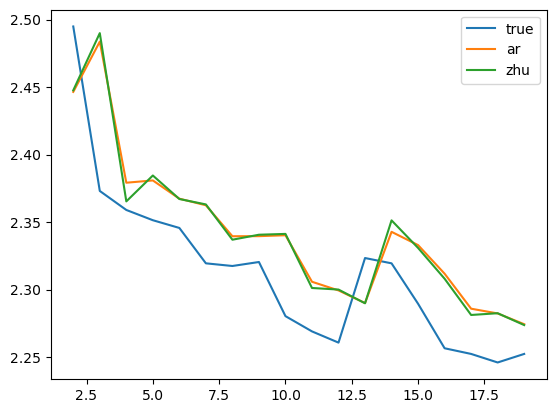

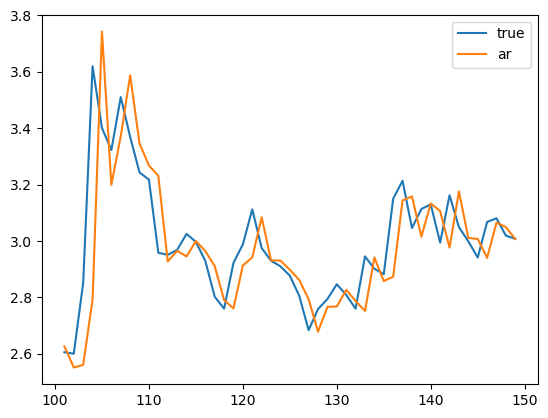

In [18]:
df_result[(df_result.index<20)&(df_result.index>1)][['true','ar','zhu']].plot()
df_result[(df_result.index<150)&(df_result.index>100)][['true','ar']].plot()

<AxesSubplot:>

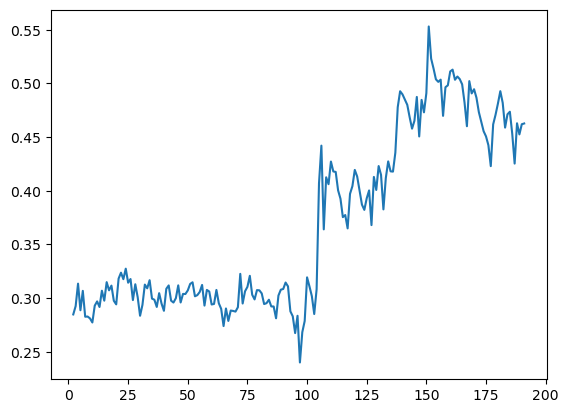

In [19]:
df_result[(df_result.index<192)&(df_result.index>1)]['H'].plot()

In [20]:
sst=1
eed=200

In [21]:
hmse(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed]),hmae(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])

(0.0010690610008686537, 0.02193151396966333)

In [22]:
hmse(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed]),hmae(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])

(0.0010834095540463743, 0.022057000239701995)

In [23]:
def mse(y_true,y_pred):
    return np.mean(np.power(np.abs(y_true-y_pred),2))

def mae(y_true,y_pred):
    return np.mean(np.abs(y_true-y_pred))


mse(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed]), mae(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])



(0.009672868632651516, 0.059640889000523896)

In [24]:
mse(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed]), mae(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])

(0.009869640167685092, 0.05996901783362187)

In [25]:
r2 = r2_score(df_result['true'].values[sst:eed],df_result['zhu'].values[sst:eed])
r2 

0.8953680092099199

In [26]:
r2 = r2_score(df_result['true'].values[sst:eed],df_result['ar'].values[sst:eed])
r2 

0.893239519904081

In [27]:
# exponential to the VIX index
vixtr=np.exp(df_result['true'].values[sst:eed])
vixarrv =np.exp(df_result['zhu'].values[sst:eed])
vixar=np.exp(df_result['ar'].values[sst:eed])

In [28]:
msearrv =hmse(vixtr,vixarrv)
msearrv

0.008163099196403489

In [29]:
msear = hmse(vixtr,vixar)
msear

0.008085737223133684

In [772]:
# df_result = pd.DataFrame(result,columns=['pred','date','true','H','beta','gamma','omega','lambda','loss'])
df_result[(df_result['date']>='2017-2-1')&(df_result['date']<='2018-3-6')]

,ar,zhu,date,true,H,lambda_,value_first,z,u_tmp,u_hat,zhu_shift,ar_shift
0,2.497440,2.521207,2017-09-06,2.453588,0.281101,1.605137,0,-0.023768,0.095480,0.134137,2.420882,2.435477
1,2.435477,2.420882,2017-09-07,2.446685,0.288216,1.594914,0,0.014595,0.000619,0.080362,2.447574,2.446413
2,2.446413,2.447574,2017-09-08,2.494857,0.284759,1.589249,0,-0.001161,0.012125,0.048033,2.489930,2.483645
3,2.483645,2.489930,2017-09-11,2.373044,0.292509,1.595665,0,-0.006285,0.203395,0.326881,2.365317,2.379148
4,2.379148,2.365317,2017-09-12,2.358965,0.313433,1.582539,0,0.013831,-0.017947,-0.011965,2.384489,2.380839
...,...,...,...,...,...,...,...,...,...,...,...,...
120,2.913481,2.917571,2018-02-28,2.988204,0.419413,1.876017,0,-0.004089,1.781066,1.306943,2.941811,2.941856
121,2.941856,2.941811,2018-03-01,3.112181,0.413279,1.861686,0,0.000046,1.317698,1.164403,3.087451,3.084029
122,3.084029,3.087451,2018-03-02,2.975019,0.400099,1.847020,0,-0.003422,2.402372,1.561009,2.927093,2.931146
123,2.931146,2.927093,2018-03-05,2.930127,0.387080,1.827861,0,0.004053,0.860222,0.970047,2.932751,2.930613


In [773]:
df_result['true_shift'] = df_result['true'].shift(1)
df_result['test'] = df_result['true_shift']-df_result['z']
df_result[['test','zhu','true']]

,test,zhu,true
0,NaN,2.521207,2.453588
1,2.438993,2.420882,2.446685
2,2.447846,2.447574,2.494857
3,2.501141,2.489930,2.373044
4,2.359213,2.365317,2.358965
...,...,...,...
195,2.494416,2.497814,2.483239
196,2.483489,2.501753,2.510412
197,2.511247,2.521796,2.591516
198,2.591769,2.593233,2.548664


<AxesSubplot:>

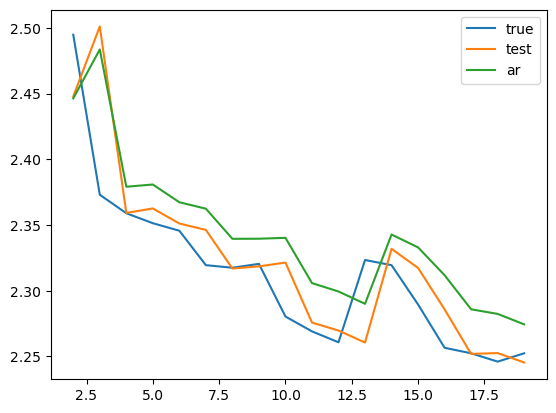

In [774]:
df_result[(df_result.index<20)&(df_result.index>1)][['true','test','ar']].plot()

In [775]:
df_result.to_csv("./beta_gamma_omega_0128_%s.txt"%n,sep='\t')

In [780]:
msear1 = hmse(df_result['true'],df_result['ar'])
msear1

0.0010795896271394167

In [779]:
msear2 = hmse(df_result['true'],df_result['test'])
msear2

0.0009808596820837904

In [778]:
msear = hmse(df_result['true'],df_result['zhu'])
msear

0.0010675133021140588

In [781]:
(msear1-msear)/msear1

0.011186032842272228

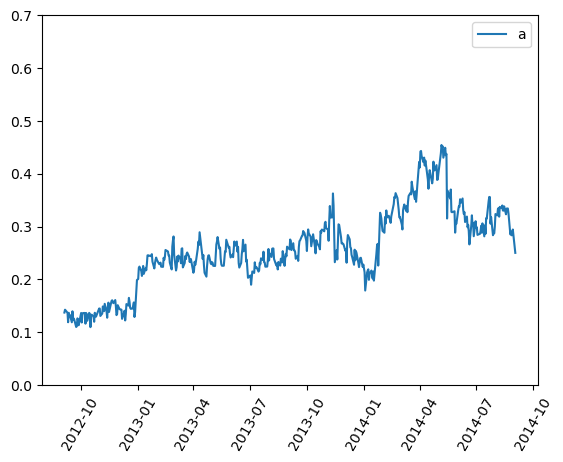

In [34]:
import matplotlib.pyplot as plt 
df_result['date'] = pd.to_datetime(df_result['date'])

plt.plot(df_result['date'],df_result['a'],label='a')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,0.7)
plt.show()

In [35]:
df_result['a'].mean()

0.25876801134860017

In [27]:
r2 = r2_score(df_result['true'].values,df_result['pred'].values)
r2 

0.4577825198633205

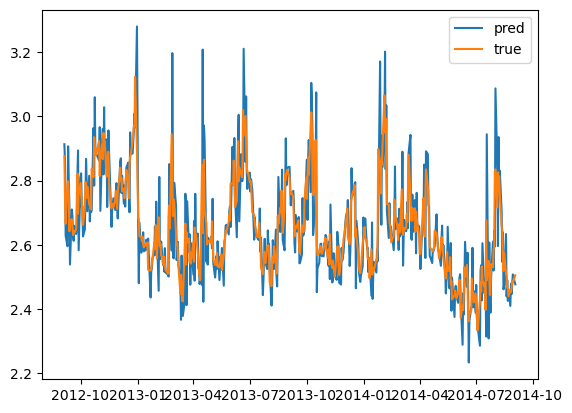

In [28]:
import matplotlib.pyplot as plt
plt.plot(df_result['date'],df_result['pred'],label='pred')
plt.plot(df_result['date'],df_result['true'],label='true')
plt.legend()
plt.show()

In [29]:
from statsmodels.tsa.ar_model import AutoReg

def ar(date,n=500):
    df = prepare_data('./data/VIXdata.txt')
    # date = '20120101'
    df_ori = obtain_train_ar(df,n,date)
    acf_params = acf(df_ori['log_vix'],nlags=50)
    model = AutoReg(df_ori['log_vix'], lags=len(acf_params[acf_params>0.5])).fit()
    result = model.forecast(1)

    df_true = obtain_true_ar(df,n+1,date)
    date_ = df_true['Date'].values[-1]
    true_value = df_true['log_vix'].values[-1]
    print(type(result))
    # print()
    return [result.values[-1],date_,true_value,len(acf_params[acf_params>0.5])],model


In [30]:
date_list

['20120201',
 '20120202',
 '20120203',
 '20120206',
 '20120207',
 '20120208',
 '20120209',
 '20120210',
 '20120213',
 '20120214',
 '20120215',
 '20120216',
 '20120217',
 '20120221',
 '20120222',
 '20120223',
 '20120224',
 '20120227',
 '20120228',
 '20120229',
 '20120301',
 '20120302',
 '20120305',
 '20120306',
 '20120307',
 '20120308',
 '20120309',
 '20120312',
 '20120313',
 '20120314',
 '20120315',
 '20120316',
 '20120319',
 '20120320',
 '20120321',
 '20120322',
 '20120323',
 '20120326',
 '20120327',
 '20120328',
 '20120329',
 '20120330',
 '20120402',
 '20120403',
 '20120404',
 '20120405',
 '20120409',
 '20120410',
 '20120411',
 '20120412',
 '20120413',
 '20120416',
 '20120417',
 '20120418',
 '20120419',
 '20120420',
 '20120423',
 '20120424',
 '20120425',
 '20120426',
 '20120427',
 '20120430',
 '20120501',
 '20120502',
 '20120503',
 '20120504',
 '20120507',
 '20120508',
 '20120509',
 '20120510',
 '20120511',
 '20120514',
 '20120515',
 '20120516',
 '20120517',
 '20120518',
 '20120521',

In [ ]:
result_ar = []
for date in date_list:
    result_,model = ar(date,n=n)
    result_ar.append(result_)
result_ar
df_result_ar = pd.DataFrame(result_ar,columns=['pred','date','true','K'])

In [32]:
df_result_ar

,pred,date,true,K
0,2.884128,2012-09-05,2.875822,9
1,2.879716,2012-09-06,2.747271,9
2,2.752111,2012-09-07,2.665838,9
3,2.695543,2012-09-10,2.789937,10
4,2.805013,2012-09-11,2.797891,10
...,...,...,...,...
495,2.470383,2014-08-26,2.453588,7
496,2.463399,2014-08-27,2.466403,7
497,2.482532,2014-08-28,2.489065,7
498,2.490154,2014-08-29,2.483239,7


In [33]:
model.summary().as_text()

'                            AutoReg Model Results                             \n==============================================================================\nDep. Variable:                log_vix   No. Observations:                  150\nModel:                     AutoReg(6)   Log Likelihood                 203.066\nMethod:               Conditional MLE   S.D. of innovations              0.059\nDate:                Sat, 28 Jan 2023   AIC                           -390.132\nTime:                        19:17:34   BIC                           -366.373\nSample:                             6   HQIC                          -380.478\n                                  150                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------\nconst          0.3344      0.106      3

In [34]:
df_result_ar['date'] = pd.to_datetime(df_result_ar['date'])

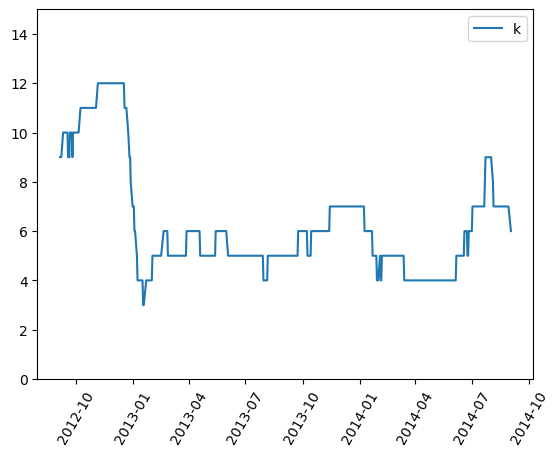

In [35]:
import matplotlib.pyplot as plt
plt.plot(df_result_ar['date'],df_result_ar['K'],label='k')
plt.xticks(rotation=60)
plt.legend()
plt.ylim(0,15)
plt.show()

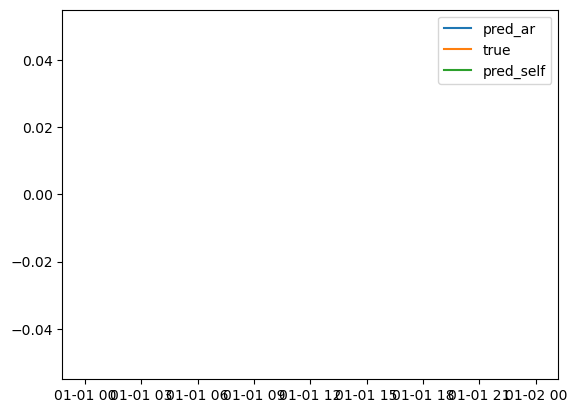

In [36]:
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result_ar[df_result_ar['date']<'2012-04-01']['pred'],label='pred_ar')
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result_ar[df_result_ar['date']<'2012-04-01']['true'],label='true')
plt.plot(df_result_ar[df_result_ar['date']<'2012-04-01']['date'],
         df_result[df_result['date']<'2012-04-01']['pred'],label='pred_self')
plt.legend()
plt.show()

In [37]:
r2_ar = r2_score(df_result_ar['true'].values,df_result_ar['pred'].values)
r2_ar

0.7548442770022457

In [38]:
df_result_ar['err'] = abs(df_result_ar['pred']-df_result_ar['true'])

In [39]:
(df_result_ar['err']*df_result_ar['err']).mean()

0.004582479525942847

In [40]:
df_result['err'] = abs(df_result['pred']-df_result['true'])
(df_result['err']*df_result['err']).mean()

0.010135192729550987

In [41]:
df_result['err'].mean()

0.0701124969389156

In [42]:
df_result_ar['err'].mean()

0.049081737010483704

In [43]:
from sklearn.metrics import r2_score

In [44]:
r2_score(df_result['true'],df_result['pred'])

0.4577825198633205

In [45]:
r2_score(df_result_ar['true'],df_result_ar['pred'])

0.7548442770022457

In [46]:
hmse(df_result_ar['true'],df_result_ar['pred'])

0.0006193006048058637

In [47]:
hmae(df_result_ar['true'],df_result_ar['pred'])

0.018328269391963862

In [48]:
hmse(df_result['true'],df_result['pred'])

0.0013804103551676263

In [49]:
hmae(df_result['true'],df_result['pred'])

0.026128723027383678

In [50]:
pd.DataFrame([[hmse(df_result['true'],df_result['pred']),
              hmae(df_result['true'],df_result['pred']),
              hmse(df_result_ar['true'],df_result_ar['pred']),
              hmae(df_result_ar['true'],df_result_ar['pred']),
              r2_score(df_result['true'],df_result['pred']),
              r2_score(df_result_ar['true'],df_result_ar['pred'])
              ]],columns = ['hmse_','hmae','hmse_ar','hmae_ar','r2_','r2_ar'])

,hmse_,hmae,hmse_ar,hmae_ar,r2_,r2_ar
0,0.00138,0.026129,0.000619,0.018328,0.457783,0.754844


In [51]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# # Create some mock data
# t = np.arange(0.01, 10.0, 0.01)
# data1 = np.exp(t)
# data2 = np.sin(2 * np.pi * t)
#
# fig, ax1 = plt.subplots()
#
# # color = 'green'
# ax1.set_xlabel('date')
# # ax1.set_xticks(ratation=60)
# ax1.set_ylabel('H',color='r')
# ax1.plot(df_result['date'], df_result['H'],'-s',color='r')
# ax1.tick_params(axis='y')
# ax1.set_ylim((0.1,0.5))
#
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#
#
# ax2.set_ylabel('k',color='b')  # we already handled the x-label with ax1
# ax2.plot(df_result_ar['date'], df_result_ar['K'],'-^',color='b')
# ax2.tick_params(axis='y')
# ax2.set_ylim((0,20))
#
# for tl in ax1.get_xticklabels():
#     tl.set_rotation(45)
#
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# fig.savefig("./H_k.png",dpi=200)
# plt.show()

In [52]:
# import numpy as np
# import matplotlib.pyplot as plt

# def function(x, p):
#     return x ** (2 * p + 1) / (1 + x ** (2 * p))

# pparam = dict(xlabel='Voltage (mV)', ylabel='Current ($\mu$A)')

# x = np.linspace(0.75, 1.25, 201)
# with plt.style.context(['science']):
#     fig, ax = plt.subplots()
#     for p in [10, 15, 20, 30, 50, 100]:
#         ax.plot(x, function(x, p), label=p)
#     ax.legend(title='Order')
#     ax.autoscale(tight=True)
#     ax.set(**pparam)
#     # fig.savefig('figures/fig1.pdf')
#     # fig.savefig('figures/fig1.jpg', dpi=300)


In [53]:
# df_result_all

In [54]:
colu1 = df_result.columns.tolist()
colu1 = [i+'_self' for i in colu1]
df_result.columns = colu1
df_result.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825


In [55]:
colu2 = df_result_ar.columns.tolist()
colu2 = [i+'_ar' for i in colu2]
df_result_ar.columns = colu2
df_result_ar.head()

,pred_ar,date_ar,true_ar,K_ar,err_ar
0,2.884128,2012-09-05,2.875822,9,0.008306
1,2.879716,2012-09-06,2.747271,9,0.132445
2,2.752111,2012-09-07,2.665838,9,0.086273
3,2.695543,2012-09-10,2.789937,10,0.094394
4,2.805013,2012-09-11,2.797891,10,0.007122


In [56]:
df_result_all = pd.merge(df_result,df_result_ar,how='left',left_on=['date_self'],right_on=['date_ar'])
df_result_all.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122


In [57]:
df_result_all['err'] = df_result_all['err_self']+df_result_all['err_ar']

In [58]:
df_result_all.head()

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar,err
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306,0.045717
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445,0.246473
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273,0.123064
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394,0.288344
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122,0.115947


In [59]:
df_result_all = df_result_all[df_result_all['err']<0.3]

In [60]:
df_result_all

,pred_self,date_self,true_self,H_self,beta_self,gamma_self,omega_self,lambda_self,loss_self,err_self,pred_ar,date_ar,true_ar,K_ar,err_ar,err
0,2.913233,2012-09-05,2.875822,0.424137,1.000000,1.000000,-0.000373,1.023790,9.345038e-15,0.037411,2.884128,2012-09-05,2.875822,9,0.008306,0.045717
1,2.861298,2012-09-06,2.747271,0.427066,1.000000,1.000000,0.000042,1.030570,8.412069e-15,0.114027,2.879716,2012-09-06,2.747271,9,0.132445,0.246473
2,2.629048,2012-09-07,2.665838,0.432408,1.000000,1.000000,0.000703,1.035713,8.609586e-15,0.036791,2.752111,2012-09-07,2.665838,9,0.086273,0.123064
3,2.595988,2012-09-10,2.789937,0.430529,1.000002,1.000005,0.000179,1.029664,1.950676e-11,0.193950,2.695543,2012-09-10,2.789937,10,0.094394,0.288344
4,2.906716,2012-09-11,2.797891,0.406131,1.000000,1.000000,0.000254,1.019760,8.778948e-15,0.108825,2.805013,2012-09-11,2.797891,10,0.007122,0.115947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2.479296,2014-08-26,2.453588,0.609232,1.000000,1.000000,0.000668,1.328015,8.567378e-15,0.025708,2.470383,2014-08-26,2.453588,7,0.016795,0.042503
496,2.446898,2014-08-27,2.466403,0.560856,1.000000,1.000000,-0.000280,1.351382,9.185132e-15,0.019506,2.463399,2014-08-27,2.466403,7,0.003004,0.022509
497,2.478346,2014-08-28,2.489065,0.321238,1.000000,1.000000,-0.003993,1.314696,8.136280e-14,0.010718,2.482532,2014-08-28,2.489065,7,0.006532,0.017251
498,2.508183,2014-08-29,2.483239,0.334676,1.000000,1.000000,-0.003486,1.315516,6.270536e-14,0.024944,2.490154,2014-08-29,2.483239,7,0.006915,0.031860


In [61]:
pd.DataFrame([[hmse(df_result_all['true_self'],df_result_all['pred_self']),
              hmae(df_result_all['true_self'],df_result_all['pred_self']),
              hmse(df_result_all['true_ar'],df_result_all['pred_ar']),
              hmae(df_result_all['true_ar'],df_result_all['pred_ar']),
              r2_score(df_result_all['true_self'],df_result_all['pred_self']),
              r2_score(df_result_all['true_ar'],df_result_all['pred_ar'])
              ]],columns = ['hmse_','hmae','hmse_ar','hmae_ar','r2_','r2_ar'])

,hmse_,hmae,hmse_ar,hmae_ar,r2_,r2_ar
0,0.000775,0.021662,0.000415,0.015888,0.680777,0.830225


In [4]:
from statsmodels.tsa.ar_model import AutoReg

df = prepare_data('./data/VIXdata.txt')
date = '20120101'
n =500
df_ori = obtain_train_ar(df,n,date)
acf_params = acf(df_ori['log_vix'],nlags=50)
model = AutoReg(df_ori['log_vix'], lags=len(acf_params[acf_params>0.5])).fit()
result = model.forecast(1)

C:\Users\gaoxc\anaconda3\envs\papers\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
type(model.params)

pandas.core.series.Series

In [9]:
model.params['const']

0.17566654768773923

In [12]:
np.array(model.params)*np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])

array([ 0.17566655,  1.62716087,  0.16275258,  0.17640345,  0.13004872,
       -0.46828656,  0.67465697, -0.24842408,  0.28376093, -0.17144288,
        0.30767221,  0.10902138, -0.44760793, -0.08968734])

In [13]:
np.dot(np.array(model.params),np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14]))

2.2216948647929113

In [3]:
# import numpy as np
# 2 * np.linspace(0, 1,10)

In [1]:
(1/501)**0.6

0.023993707736588134

In [2]:
1/500

0.002

In [137]:
n = 200
H = 0.15
S = np.zeros([n+2,n+2])

for i in range(1,n+2):
    for j in range(1,n+2):
        S[i][j] = (np.power(i,2*H)+ np.power(j,2*H) -np.power(np.power(j-i,2),H))/2
S = S[1:,1:]
A = S[0:n,0:n]
A_ = np.linalg.inv(A)
B_T = S[-1,0:n]

In [138]:
S

array([[1.        , 0.61557221, 0.57962238, ..., 0.50369538, 0.50368241,
        0.50366954],
       [0.61557221, 1.23114441, 0.81076679, ..., 0.62297606, 0.62295   ,
        0.62292415],
       [0.57962238, 0.81076679, 1.39038917, ..., 0.70632011, 0.70628085,
        0.70624192],
       ...,
       [0.50369538, 0.62297606, 0.70632011, ..., 4.89390938, 4.39759178,
        4.28568912],
       [0.50368241, 0.62295   , 0.70628085, ..., 4.39759178, 4.90127419,
        4.40494373],
       [0.50366954, 0.62292415, 0.70624192, ..., 4.28568912, 4.40494373,
        4.90861327]])

In [101]:
A_

array([[ 1.57750092e+00, -4.86960383e-01, -1.75928016e-01, ...,
        -4.98762685e-04, -7.19529792e-04, -1.29323960e-03],
       [-4.86960383e-01,  1.61706329e+00, -4.66846738e-01, ...,
        -3.45772709e-04, -4.98762685e-04, -8.96362070e-04],
       [-1.75928016e-01, -4.66846738e-01,  1.62728909e+00, ...,
        -2.68490775e-04, -3.87235377e-04, -6.95855574e-04],
       ...,
       [-4.98762685e-04, -3.45772709e-04, -2.68490775e-04, ...,
         1.61706329e+00, -4.86960383e-01, -2.27926709e-01],
       [-7.19529792e-04, -4.98762685e-04, -3.87235377e-04, ...,
        -4.86960383e-01,  1.57750092e+00, -5.89238436e-01],
       [-1.29323960e-03, -8.96362070e-04, -6.95855574e-04, ...,
        -2.27926709e-01, -5.89238436e-01,  1.31308886e+00]])